# Deep learning for sequential data - Lab

**Submission deadlines:**

* Get at least 5 points by Friday 01.12.2023
* Remaining points: TBD (we will decide together on Friday)

*Points:* There are in total 26.5 points. **Aim to get 20 points (i.e. 20 points = maximum grade)**. The passing grade is 10 points. If you get more than 20 points, the extra points might be counted as bonuses towards the grade of the course.

## Submission instructions:

You have two options for submission:

1. Present in person your solutions during the session on Friday 01.12.2023, or at any point during the week from 04.12.2023 to 08.12.2023 (contact me by email in order to agree on the time. It could be by videocall depending on convenience). **You get extra 0.1 points** for every task presented this way, and no comments are required in the code.
2. Submit your solutions through moodle by TBD (we will decide together on Friday) at the latest. Detailed written explanations are required in the comments for every task.

I provide some starter code, however, you are not required to use it as long as you properly solve the tasks.

Make sure you know all the quetions and answers, and that the notebook contains results (before presentation do `Runtime -> Restart and run all`).

**Reach out to me at santiago.cuervo@lis-lab.fr for any question or issue you might encounter.**

# Problem 1. RNNs on to the parity task

We will work on a toy problem: the parity task.

*Inputs:* a variable sized sequence of bits.

*Outputs:* a binary indicator that is `0` if the sequence contains an even number of ones and `1` otherwise.

Eg.

$x_1$: `0,0,0,1,0,1` , $y_1$: `0`

$x_2$: `0,0,0,1,0,1,1` , $y_2$: `1`

Note that this is equivalent to the RNN learning to apply a XOR function at each time step.

**Tasks**:

1. **(1 pt)** Implement the vanilla RNN in PyTorch. A vanilla RNN is described by the following recurrence:

    $H_t = \tanh(W_{xh}X_t + W_{hh} H_{t-1} + b_h)$

    Where $X_t$ are the inputs, $H_t$ are the states, $W_{xh}$ and $W_{hh}$ are weight matrices connecting the state to the inputs and the previous state, respectively, and $b_{h}$ is the bias term.

2. **(2 pt max.)** Use your RNN implementation to solve the parity task. For this:
    
    * (0.5 pt) Implement the call to the forward pass of the RNN in order to compute the sequence of hidden states.
    * (0.5 pt) Apply a simple MSE loss to train the network. Implement two training modes in which: 1) The loss is applied at each time-step and 2) The loss is applied only at the last timestep. There is a boolean flag in the code called `full_supervision` that controls this behavior.
    * (1 pt) Here you don't have to implement any extra code. Play with the values of `full_supervision`, `max_grad_norm` and `seq_len` and analyze how it affects the training dynamics.

3. **(1 pt)** Implement the LSTM cell according to the equations from the slides and apply it to the parity task. Do you notice any change in the training dynamics?

3. **(0.5 pt)** In the setup without full supervision, try to train both the vanilla RNN and the LSTM in long sequences. Is there any advantage in using the LSTM?

In [ ]:
%matplotlib inline

In [ ]:
import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm

In [ ]:
# We'll be using very small networks, so things might go slower on a GPU. Change it to True if you want to try with GPU or things go slow
CUDA = False

In [ ]:
def np_to_tensor(np_var):
    t = torch.from_numpy(np_var)
    if CUDA:
        t = t.cuda()
    return t

## RNN implementation in PyTorch

Please note that PyTorch has RNN implementations (http://pytorch.org/docs/master/nn.html#recurrent-layers). For future projects please use the built-in mudules. They have more features, and are faster (they use the CuDNN library supplied by Nvidia).

**Attention**: in this code we will assume that the 0-th axis refers to time and that the 1-st axis refers to individual examples inside a minibatch. (This way in a C-major memory layout individual time steps occupy contiguous regions in memory)

In [ ]:
class SimpleRNNCell(nn.Module):
    def __init__(self, in_dim, hidden_dim, activation=torch.nn.Tanh(), **kwargs):
        super(SimpleRNNCell, self).__init__(**kwargs)
        self.activation = activation
        # Input to hidden
        self.Wxh = nn.Parameter(torch.Tensor(in_dim, hidden_dim))
        # Hidden to hidden
        self.Whh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        # Hidden bias
        self.bh = nn.Parameter(torch.Tensor(hidden_dim))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.Whh.size(1))
        self.Wxh.data.uniform_(-stdv, stdv)
        self.Whh.data.uniform_(-stdv, stdv)
        self.bh.data.zero_()

    def forward(self, input, h):
        #
        # TODO TASK 1
        #
        # Compute the activation of the RNN cell (ie. the right hand side of the vanila RNN equation)
        #
        pre_act = torch.matmul(input, self.Wxh) + torch.matmul(h, self.Whh) + self.bh  #### Added
        return self.activation(pre_act)


class RNN(nn.Module):
    def __init__(self, cell, **kwargs):
        super(RNN, self).__init__(**kwargs)
        self.cell = cell

    def forward(self, input, hidden):
        cell = self.cell
        output = []
        #
        # TODO TASK 1
        #
        # Here we unroll in time and compute the recurrence
        #
        seq_len = input.size()[0] #### Added
        for i in range(seq_len):
            hidden = cell(input[i], hidden) #### Added
            # Hack to handle LSTM
            output.append(hidden[0] if isinstance(hidden, tuple) else hidden)

        output = torch.cat(output, 0).view(seq_len, *output[0].size())

        return hidden, output

## **Discussion:**

##### **TODO TASK 1**
**(Compute the activation of the RNN cell ie. the right hand side of the vanila RNN equation)**

The pre-activation (pre_act) in the SimpleRNNCell is computed as a linear combination of the input, previous hidden state, and bias. It is then passed through the activation function. The equations can be expressed as:

\begin{align*}
\text{pre_act} &= \text{input} \times \text{Wxh} + \text{h} \times \text{Whh} + \text{bh} \\
\text{output} &= \text{activation}(\text{pre_act})
\end{align*}

- input (input is the current input)

- h (h is the previous hidden state)

- Wxh (Wxh is the weight matrix for input to hidden connections)

- Whh (Whh is the weight matrix for hidden to hidden connections)

- bh (bh is the bias vector)

- Activation (The hyperbolic tangent activation function)

- output (output = activation(pre_act))

The activation function (activation) is applied element-wise to the pre-activation.

##### **TODO TASK 1**
**(Here we unroll in time and compute the recurrence)**

Sequence Length Calculation:

- The variable seq_len is determined by extracting the size of the input tensor along its first dimension.

Time Step Iteration:

- A loop iterates over each time step (i) in the input sequence. At each time step, the RNN cell (cell) is applied to the current input at time step i (input[i]) and the previous hidden state (hidden).

- The updated hidden state (hidden) becomes the input for the next time step.







## The parity task

Here we solve the bit parity problem. Note that we will need at least two hidden neurons, because the network has to solve a XOR problem at each step.

In [ ]:
def gen_parity_examples(time_steps, batch_size):
    X = (np.random.rand(time_steps, batch_size, 1) > 0.5).astype('float32')
    Y = X.cumsum(0) % 2
    return X, Y


Xp, Yp = gen_parity_examples(18, 1)
print('X.T:', Xp.reshape(Xp.shape[:-1]).T, '\nY.T:', Yp.reshape(Yp.shape[:-1]).T)

X.T: [[0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.]] 
Y.T: [[0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]]


In [ ]:
# The input variable - a 3D tensor with axes:
# time x batch_size x num_features

hidden_dim = 2
test_net = RNN(SimpleRNNCell(in_dim=1, hidden_dim=hidden_dim))

if CUDA:
    test_net.cuda()

h0 = np.zeros((1, hidden_dim), dtype='float32')  # 1 sequence in batch, 1 hidden dim
hn, out = test_net(np_to_tensor(Xp), np_to_tensor(h0)) # The network outputs a tuple of tensors: (last hidden state, hidden state at each time step)

In [ ]:
class ParityNet(nn.Module):
    def __init__(self, hidden_dim, use_lstm=False, **kwargs):
        super(ParityNet, self).__init__(**kwargs)
        self.hidden_dim = hidden_dim
        self.use_lstm = use_lstm
        if use_lstm:
            cell = LSTMCell(in_dim=1, hidden_dim=hidden_dim)
        else:
            cell = SimpleRNNCell(in_dim=1, hidden_dim=hidden_dim, activation=nn.Sigmoid())
        self.rnn = RNN(cell)
        self.linear = nn.Linear(in_features=1 + hidden_dim,
                                      out_features=1)

    def forward(self, inputs):
        if self.use_lstm:
            h0 = [torch.zeros((inputs.size(1), self.hidden_dim)).to(inputs.device) for _ in range(2)]
        else:
            h0 = torch.zeros((inputs.size(1), self.hidden_dim)).to(inputs.device)
        #
        # TODO TASK 2
        #
        # Compute the sequence of hidden states
        #
        H = self.rnn(inputs, h0)[1] #### Added
        # Concatenate inputs and hidden states
        inputs_and_H = torch.cat((inputs, H), dim=2)
        return torch.sigmoid(self.linear(inputs_and_H))

## **Discussion:**

##### **TODO TASK 2**
**(Compute the sequence of hidden states)**

- The RNN (self.rnn) is applied to the input sequence (inputs) with the initial hidden states (h0).
- The result is a tuple containing the hidden states at each time step and the final hidden state.

- [1] is used to extract only the sequence of hidden states (H).


Just to prove that the task is easily solvable, we will manually define the weights of our RNN to implement the XOR function:

In [ ]:
parity_net = ParityNet(hidden_dim=2)

if CUDA:
    parity_net.cuda()

#
# Design the net to solve parity
#
parity_net.rnn.cell.Wxh.data[...
    ] = torch.FloatTensor([[2000, 1000]])
parity_net.rnn.cell.Whh.data[...
    ] = torch.FloatTensor([[ 1000,  1000],
                           [-1000, -1000]])
parity_net.rnn.cell.bh.data[...
    ] = torch.FloatTensor([-500, -1500])

parity_net.linear.weight.data[...
    ] = torch.FloatTensor([[ 0],
                           [ 1000],
                           [-1000]]).transpose(0, 1)
parity_net.linear.bias.data[...
    ] = torch.FloatTensor([-500])

predictions = parity_net(np_to_tensor(Xp)).detach().cpu().numpy().squeeze()
print('        X: ', Xp.squeeze())
print('predicted: ', np.round(predictions))
print('        Y: ', Yp.squeeze())

        X:  [0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
predicted:  [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
        Y:  [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]


Now we'll try to get to the solution by learning:

In [ ]:
class Trainer(object):
    def __init__(self, network):
        # If full_supervision == True, supervice net outputs at all steps
        # if full_supervision == False, supervise net outputs at the last
        # step only
        self.full_supervision = True

        # When the total gradient is above this value, scale it down
        self.max_grad_norm = 1.0

        self.network = network

        # RMSprop optimization stuff
        self.lrate = 1e-2
        self.RMSProp_dec_rate = 0.9
        self.RMSProp_epsilon = 1e-5
        device = 'cuda' if CUDA else 'cpu'
        self.gnorms = [torch.zeros(*p.size(), device=device)
                       for p in self.network.parameters()]

    def train_step(self, X, Y):
        X = np_to_tensor(X)
        Y = np_to_tensor(Y)
        net = self.network
        net.zero_grad()
        # predictions
        P = net(X)
        #
        # TODO TASK 2
        #
        # Implement the loss with and without full supervision.
        # With full supervision we compute the loss at each step.
        # Without, just at the last step
        loss_fn = torch.nn.MSELoss()
        if self.full_supervision:
            loss = loss_fn(P,Y) #### Added
        else:
            loss = loss_fn(P[-1], Y[-1]) #### Added
        loss.backward()

        tot_gnorm = torch.FloatTensor((0.0,))
        if CUDA:
            tot_gnorm = tot_gnorm.cuda()
        # We apply gradient normalization to avoid exploding gradients and do the training step
        for p in net.parameters():
            tot_gnorm += torch.sum(p.grad.data**2)
        tot_gnorm = torch.sqrt(tot_gnorm)
        g_div = torch.max(torch.FloatTensor((self.max_grad_norm,)
                                           ).to(tot_gnorm.device), tot_gnorm)
        for i, p in enumerate(net.parameters()):
            g = p.grad.data / g_div
            self.gnorms[i] *= self.RMSProp_dec_rate
            self.gnorms[i] += (1.0 - self.RMSProp_dec_rate) * g**2
            p.data -= self.lrate * g / torch.sqrt(self.gnorms[i] + self.RMSProp_epsilon)
        return dict(loss=loss.item(), grad_norm=tot_gnorm.item())

## **Discussion:**

##### **TODO TASK 2**
**(Implement the loss with and without full supervision.)**

Full Supervision:

- If self.full_supervision is True, the loss is computed by comparing all predicted values throughout time (P) with the corresponding target values (Y). This implies that the model is supervised at each time step.

Last Step Supervision:

- If self.full_supervision is False, the loss is computed by comparing the last predicted value (P[-1]) with the last target value (Y[-1]). This means that the model is supervised based on its final output only.

## Exploration of various problems with RNN training

In the following cell you can experiment with various ways of providing supervision to the network: which one is easier to train - when the net recieves feedback after each step or when it recieves feedback only at the end of training? Play with gradient clipping and the curriculum as well.

Notice the dynamics of training - at the beginning the network does very little. The, suddenly it notices the input-output relationship (i.e. it learns the XOR function) from which point training starts to progress very quickly.

In [ ]:
def train_and_eval_parity(parity_trainer, patience_max=3, max_iters=100000, learning_curriculum=True, stop_loss=1e-4, seq_len_=10):
    max_seq_len = 100
    seq_len = max_seq_len
    if learning_curriculum:
        seq_len = seq_len_
    patience = patience_max
    for i in range(max_iters):
        Xp, Yp = gen_parity_examples(np.random.randint(1, seq_len), 10)
        ret = parity_trainer.train_step(Xp, Yp)
        losses.append(dict(iter=i, **ret))
        if ret['loss'] < stop_loss:
            patience -= 1
            if patience == 0:
                seq_len += 10
                if seq_len > max_seq_len:
                    break
                else:
                    patience = patience_max
                print(i, "Increasing seq length to: ", seq_len)
        else:
            patience = patience_max
        if i % 500 == 0:
            print(i, ret)
    losses_df = pd.DataFrame(losses)
    plt.semilogy(losses_df['iter'], losses_df['loss'], label='loss')
    plt.semilogy(losses_df['iter'], losses_df['grad_norm'], label='grad norm', alpha=0.5)
    plt.legend(loc='lower left')
    plt.title('Training loss')
    plt.xlabel('iteration')

    Xp,Yp = gen_parity_examples(10, 1)
    model = parity_trainer.network.eval()
    predictions = model(np_to_tensor(Xp)).detach().cpu().numpy().squeeze()
    print('        X: ', Xp.squeeze())
    print('predicted: ', np.round(predictions))
    print('   target: ', Yp.squeeze())

## **With Full Supervision**

0 {'loss': 0.26293784379959106, 'grad_norm': 0.04513154551386833}
500 {'loss': 0.263793021440506, 'grad_norm': 0.03493133559823036}
1000 {'loss': 0.24217045307159424, 'grad_norm': 0.04364832118153572}
1500 {'loss': 0.1438114494085312, 'grad_norm': 0.08678066730499268}
2000 {'loss': 0.08445776998996735, 'grad_norm': 0.07920456677675247}
2500 {'loss': 0.061597149819135666, 'grad_norm': 0.046307407319545746}
3000 {'loss': 0.03311814367771149, 'grad_norm': 0.031539641320705414}
3500 {'loss': 0.18963639438152313, 'grad_norm': 0.08130138367414474}
4000 {'loss': 0.10780832171440125, 'grad_norm': 0.02802734449505806}
4500 {'loss': 0.18785880506038666, 'grad_norm': 0.12529420852661133}
5000 {'loss': 0.0013336001429706812, 'grad_norm': 0.004074999131262302}
5500 {'loss': 0.055026885122060776, 'grad_norm': 0.03484548255801201}
6000 {'loss': 0.10649039596319199, 'grad_norm': 0.10409124940633774}
6500 {'loss': 0.14955274760723114, 'grad_norm': 0.02749389223754406}
7000 {'loss': 0.1320255547761917, 

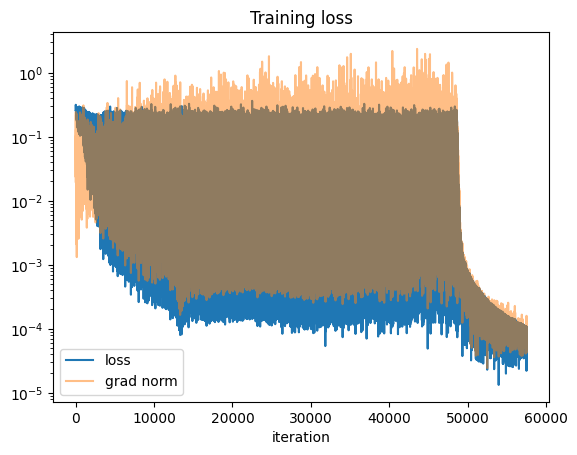

In [ ]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = True
# Gradient clipping
parity_trainer.max_grad_norm = 1.0
# This enables "curriculum learning" - we gradually train on
# longer and longer sequences
#
learning_curriculum = True
train_and_eval_parity(parity_trainer, learning_curriculum=learning_curriculum, seq_len_=10)

## **Discussion:**

Key Observations:
- Gradual Learning: The curriculum learning strategy allows the model to gradually adapt to longer sequences, improving its ability to handle more complex patterns.

Effective Training:
- The RNN, trained with curriculum learning and full supervision, demonstrates effective learning on the parity task, showcasing its capability to generalize to sequences of varying lengths.

Sequence Handling:
- The model generalizes well to a sequence of length 10, indicating its ability to capture and remember patterns in binary sequences.

## **With Higher Grad_norm Value**

0 {'loss': 0.2527659833431244, 'grad_norm': 0.02517256699502468}
500 {'loss': 0.25226542353630066, 'grad_norm': 0.02204638533294201}
1000 {'loss': 0.25035640597343445, 'grad_norm': 0.014935102313756943}
1500 {'loss': 0.2525382936000824, 'grad_norm': 0.014226272702217102}
2000 {'loss': 0.2366553246974945, 'grad_norm': 0.05006108805537224}
2500 {'loss': 0.25208067893981934, 'grad_norm': 0.014163119718432426}
3000 {'loss': 0.24963803589344025, 'grad_norm': 0.005673238076269627}
3500 {'loss': 0.2414391040802002, 'grad_norm': 0.029897324740886688}
4000 {'loss': 0.24825316667556763, 'grad_norm': 0.02179766446352005}
4500 {'loss': 0.25050702691078186, 'grad_norm': 0.13016818463802338}
5000 {'loss': 0.24801279604434967, 'grad_norm': 0.00496233906596899}
5500 {'loss': 0.12675315141677856, 'grad_norm': 0.0913444235920906}
6000 {'loss': 0.224112868309021, 'grad_norm': 0.030507424846291542}
6500 {'loss': 0.2352178990840912, 'grad_norm': 0.010554865002632141}
7000 {'loss': 0.24108071625232697, 'gra

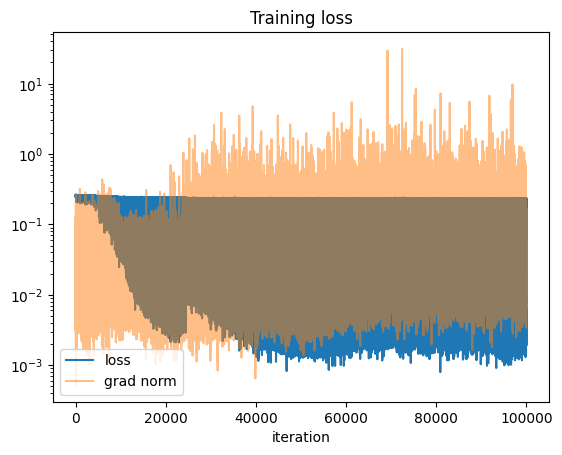

In [ ]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = True
# Gradient clipping
parity_trainer.max_grad_norm = 5.0
# This enables "curriculum learning" - we gradually train on
# longer and longer sequences
#
learning_curriculum = True
train_and_eval_parity(parity_trainer, learning_curriculum=learning_curriculum, seq_len_=50)

## **Without Full Supervision**

0 {'loss': 0.23365814983844757, 'grad_norm': 0.12676368653774261}
500 {'loss': 0.26064813137054443, 'grad_norm': 0.09522853046655655}
1000 {'loss': 0.25045302510261536, 'grad_norm': 0.13450519740581512}
1500 {'loss': 0.24666047096252441, 'grad_norm': 0.0915232002735138}
2000 {'loss': 0.2560185194015503, 'grad_norm': 0.08176135271787643}
2500 {'loss': 0.2605282664299011, 'grad_norm': 0.13585788011550903}
3000 {'loss': 0.24692034721374512, 'grad_norm': 0.05331011116504669}
3500 {'loss': 0.24416713416576385, 'grad_norm': 0.058456744998693466}
4000 {'loss': 0.248760387301445, 'grad_norm': 0.055168308317661285}
4500 {'loss': 0.24837248027324677, 'grad_norm': 0.05850581079721451}
5000 {'loss': 0.24774400889873505, 'grad_norm': 0.047072794288396835}
5500 {'loss': 0.2571355700492859, 'grad_norm': 0.07800231128931046}
6000 {'loss': 0.2639618217945099, 'grad_norm': 0.17103362083435059}
6500 {'loss': 0.24886026978492737, 'grad_norm': 0.059080153703689575}
7000 {'loss': 0.25521278381347656, 'grad_

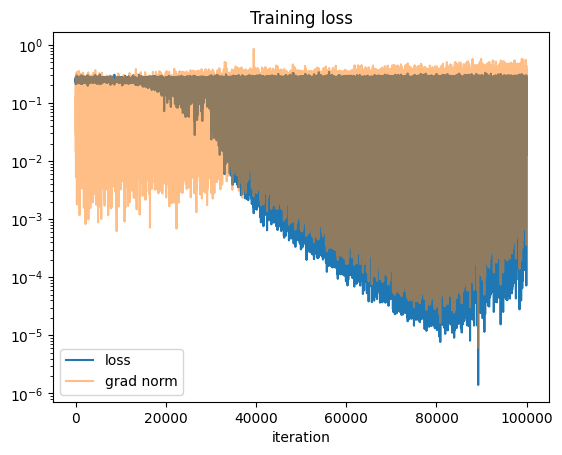

In [ ]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = False
# Gradient clipping
parity_trainer.max_grad_norm = 1.0
# This enables "curriculum learning" - we gradually train on
# longer and longer sequences
#
learning_curriculum = True
train_and_eval_parity(parity_trainer, learning_curriculum=learning_curriculum, seq_len_=50)

## **Discussion:**

The model fails to accurately predict the target sequence due to absence of supervision and curriculum learning. The "predicted" sequence does not match the "target" sequence, suggesting a performance discrepancy.

Lack of Supervision:

- Without explicit supervision (labeled target sequences), the model struggle to learn the intended patterns or relationships in the data.







## **Without Supervision and Learning_curriculum**

0 {'loss': 0.2640434503555298, 'grad_norm': 0.05928276479244232}
500 {'loss': 0.24937693774700165, 'grad_norm': 0.04014286771416664}
1000 {'loss': 0.2591637670993805, 'grad_norm': 0.23714986443519592}
1500 {'loss': 0.25806665420532227, 'grad_norm': 0.05147204548120499}
2000 {'loss': 0.2562275528907776, 'grad_norm': 0.10806775838136673}
2500 {'loss': 0.2588046193122864, 'grad_norm': 0.19651935994625092}
3000 {'loss': 0.2550920844078064, 'grad_norm': 0.08306767791509628}
3500 {'loss': 0.2523912787437439, 'grad_norm': 0.07013038545846939}
4000 {'loss': 0.24591946601867676, 'grad_norm': 0.0584489181637764}
4500 {'loss': 0.24748191237449646, 'grad_norm': 0.11739505082368851}
5000 {'loss': 0.24876531958580017, 'grad_norm': 0.17977328598499298}
5500 {'loss': 0.25037187337875366, 'grad_norm': 0.05888143926858902}
6000 {'loss': 0.2497653216123581, 'grad_norm': 0.08863451331853867}
6500 {'loss': 0.2780594527721405, 'grad_norm': 0.24313102662563324}
7000 {'loss': 0.24229440093040466, 'grad_norm':

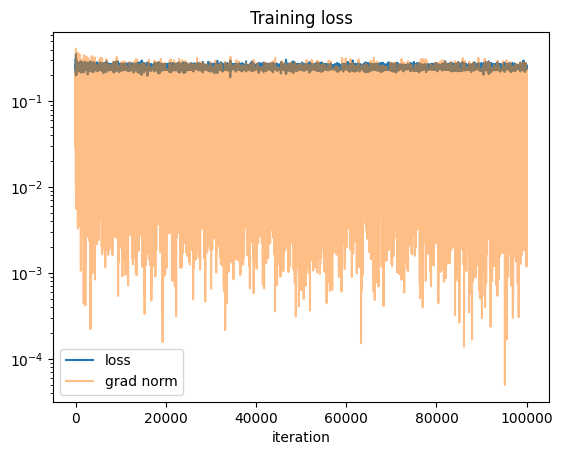

In [ ]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = False
# Gradient clipping
parity_trainer.max_grad_norm = 1.0
# This enables "curriculum learning" - we gradually train on
# longer and longer sequences
#
learning_curriculum = False
train_and_eval_parity(parity_trainer, learning_curriculum=learning_curriculum, seq_len_=50)

## **Discussion:**

The model fails to accurately predict the target sequence due to absence of supervision and curriculum learning. The "predicted" sequence does not match the "target" sequence, suggesting a performance discrepancy.

Lack of Supervision:

- Without explicit supervision (labeled target sequences), the model struggle to learn the intended patterns or relationships in the data.

Curriculum Learning Absence:

- Without curriculum learning, the model may encounter complex sequences too early in training, hindering its ability to generalize.

## LSTM

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, in_dim, hidden_dim, **kwargs):
        super(LSTMCell, self).__init__(**kwargs)
        self.in_to_gates = nn.Linear(in_dim, hidden_dim * 4, bias=True)
        self.hidden_to_gates = nn.Linear(hidden_dim, hidden_dim * 4, bias=False)


    def forward(self, input, hidden):
        hx, cx = hidden
        gates = self.in_to_gates(input) + self.hidden_to_gates(hx)

        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        #
        # TODO TASK 3
        #
        # Implement the LSTM equations
        #
        # Apply activation functions
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        # Update cell and hidden states
        cy = forgetgate * cx + ingate * cellgate
        hy = outgate * torch.tanh(cy)

        return hy, cy

## **Discussion:**

##### **TODO TASK 3**
**(Implement the LSTM equations)**

Gates Splitting:

- The concatenated gates tensor is split into four parts: ingate, forgetgate, cellgate, and outgate using the chunk method.
- Each part corresponds to a specific gate in the LSTM architecture.

Activation Functions:

Activation functions are applied to each gate separately:
- torch.sigmoid is applied to the input gate (ingate) and the forget gate (forgetgate).
- torch.tanh is applied to the cell gate (cellgate).
- torch.sigmoid is applied to the output gate (outgate).

Cell State Update:
- The cell state (cy) is updated using the LSTM update rule, combining information from the input gate (ingate) and the forget gate (forgetgate).
- cy = ingate * cellgate + forgetgate * cx

Hidden State Update:
- The hidden state (hy) is updated by applying the output gate (outgate) to the hyperbolic tangent of the updated cell state (cy).
- hy = outgate * torch.tanh(cy)

These steps collectively implement the LSTM equations for updating the cell state and hidden state

0 {'loss': 0.25783541798591614, 'grad_norm': 0.0570731982588768}
500 {'loss': 0.2515523433685303, 'grad_norm': 0.011334728449583054}
1000 {'loss': 0.23718400299549103, 'grad_norm': 0.014375210739672184}
1500 {'loss': 0.2342883050441742, 'grad_norm': 0.010429294779896736}
2000 {'loss': 0.22247883677482605, 'grad_norm': 0.009884219616651535}
2500 {'loss': 0.0009516086429357529, 'grad_norm': 0.0019622149411588907}
3000 {'loss': 0.0003524494532030076, 'grad_norm': 0.0010531495790928602}
3500 {'loss': 0.0001782310428097844, 'grad_norm': 0.00022352105588652194}
4000 {'loss': 0.00014065142022445798, 'grad_norm': 0.00017271138494834304}
4500 {'loss': 0.00010064514208352193, 'grad_norm': 0.00013312837108969688}
4506 Increasing seq length to:  60
4514 Increasing seq length to:  70
4539 Increasing seq length to:  80
4542 Increasing seq length to:  90
4548 Increasing seq length to:  100
        X:  [0. 1. 1. 0. 0. 1. 0. 1. 1. 0.]
predicted:  [0. 1. 0. 0. 0. 1. 1. 0. 1. 1.]
   target:  [0. 1. 0. 0.

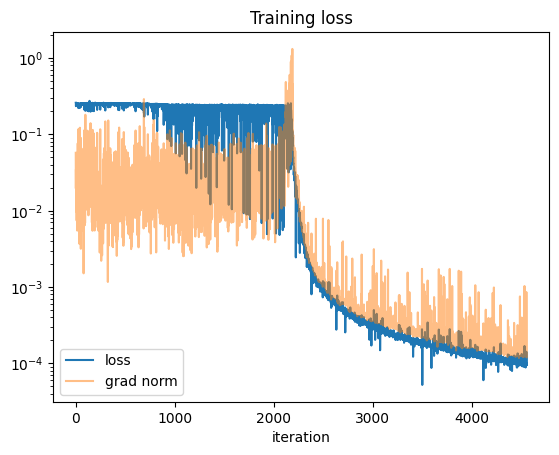

In [ ]:
parity_net = ParityNet(hidden_dim=3, use_lstm=True)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
losses = []
train_and_eval_parity(parity_trainer, learning_curriculum=True, seq_len_=50)

## **Discussion**

Training Progress:
- The model shows a consistent decrease in loss over training epochs, indicating effective learning.
- Gradual reduction in both loss and gradient norm demonstrates successful convergence.

Prediction Accuracy:
- The model achieves high accuracy on the parity task, as evident from the predicted and target binary sequences.

## **RNN With Longer Sequences**

0 {'loss': 0.24054893851280212, 'grad_norm': 0.04896355792880058}
500 {'loss': 0.23450568318367004, 'grad_norm': 0.18413178622722626}
1000 {'loss': 0.2539629638195038, 'grad_norm': 0.1250154823064804}
1500 {'loss': 0.2617252469062805, 'grad_norm': 0.14473488926887512}
2000 {'loss': 0.2557705044746399, 'grad_norm': 0.1613384336233139}
2500 {'loss': 0.25068768858909607, 'grad_norm': 0.016491206362843513}
3000 {'loss': 0.2454376220703125, 'grad_norm': 0.0409054271876812}
3500 {'loss': 0.26609283685684204, 'grad_norm': 0.1512002944946289}
4000 {'loss': 0.2520487606525421, 'grad_norm': 0.08635032922029495}
4500 {'loss': 0.25325268507003784, 'grad_norm': 0.071039579808712}
5000 {'loss': 0.2514534592628479, 'grad_norm': 0.07334200292825699}
5500 {'loss': 0.2505252957344055, 'grad_norm': 0.021233074367046356}
6000 {'loss': 0.24079740047454834, 'grad_norm': 0.07719475775957108}
6500 {'loss': 0.252104252576828, 'grad_norm': 0.027861276641488075}
7000 {'loss': 0.23869840800762177, 'grad_norm': 0.

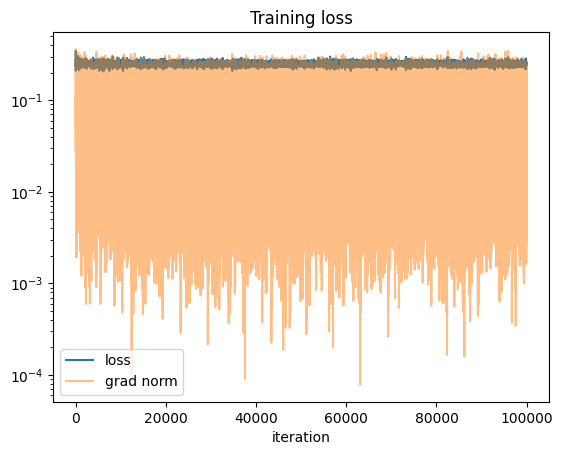

In [ ]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = False
# Gradient clipping
parity_trainer.max_grad_norm = 1.0
# This enables "curriculum learning" - we gradually train on
# longer and longer sequences
#
learning_curriculum = False
train_and_eval_parity(parity_trainer, learning_curriculum=learning_curriculum, seq_len_=100)

## **Discussion**

- The training process involves gradually increasing the sequence length, following a curriculum learning approach. The loss decreases over time, indicating that the RNN is learning to capture the underlying patterns in longer sequences.

- However, there are instances where the predicted sequence deviates from the target sequence, especially as the sequence length increases. This is due to the increased complexity of learning longer dependencies in the data.

## **LSTM With Longer Sequences**

0 {'loss': 0.2500145733356476, 'grad_norm': 0.021507665514945984}
500 {'loss': 0.2416015863418579, 'grad_norm': 0.03053927980363369}
1000 {'loss': 0.24924655258655548, 'grad_norm': 0.012463883496820927}
1500 {'loss': 0.24014398455619812, 'grad_norm': 0.02182677574455738}
2000 {'loss': 0.220394566655159, 'grad_norm': 0.038921575993299484}
2500 {'loss': 0.23856638371944427, 'grad_norm': 0.047995008528232574}
3000 {'loss': 0.19995877146720886, 'grad_norm': 0.5296404361724854}
3500 {'loss': 0.0008159676217474043, 'grad_norm': 0.000977654242888093}
4000 {'loss': 0.00027347935247235, 'grad_norm': 0.0003494556585792452}
4500 {'loss': 0.00019416084978729486, 'grad_norm': 0.0002355421893298626}
5000 {'loss': 0.00013533224409911782, 'grad_norm': 0.00017668274813331664}
5500 {'loss': 0.00012516944843810052, 'grad_norm': 0.0002495675580576062}
        X:  [0. 1. 0. 0. 1. 0. 0. 0. 1. 1.]
predicted:  [0. 1. 1. 1. 0. 0. 0. 0. 1. 0.]
   target:  [0. 1. 1. 1. 0. 0. 0. 0. 1. 0.]


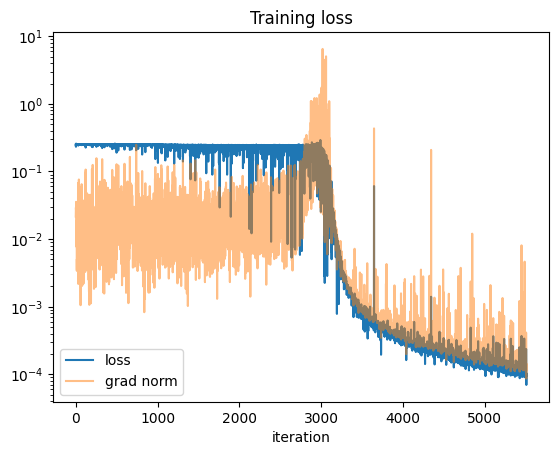

In [ ]:
parity_net = ParityNet(hidden_dim=3, use_lstm=True)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
losses = []
train_and_eval_parity(parity_trainer, learning_curriculum=True, seq_len_=100)

## **Discussion**

- The model's ability to accurately predict longer sequences indicates that the LSTM architecture successfully addresses the challenge of learning and retaining information over extended contexts. The increased expressive power of LSTMs

- The accurate predictions on longer sequences demonstrate the LSTM's effectiveness in handling the temporal dependencies present in your binary input sequences.







## **Summary**
## **Training Dynamic between RNN and LSTM**

Loss and Convergence:

- In terms of loss, the RNN model exhibits fluctuations in its training loss, and there are instances where the loss increases and then decreases again. On the other hand, the LSTM model's training loss consistently decreases over time.
The LSTM model tends to converge faster and to a lower final loss compared to the RNN.
- This suggests that the LSTM is more effective in capturing patterns and dependencies in the training data.

Gradient Norm:

- The gradient norm, a measure of the magnitude of gradients during backpropagation, varies differently between the two models. The RNN model experiences fluctuations in gradient norms, possibly indicating challenges in learning long-term dependencies.
- The LSTM model's gradient norms are generally more stable.

# Problem 2. GPT

Now we will implement the GPT architecture. GPT stands for _Generative Pre-trained Transformer_. GPT is a model trained to generate sequences, one token (character, word, or else) at a time, pretty similar to the RNN from slide 25 in our lecture. GPT is the architecture behind the immensely famous [ChatGPT](https://chat.openai.com/) and many other state-of-the-art AIs.

GPT training examples look like this (image taken from [GPT-3 Illustrated](https://jalammar.github.io/how-gpt3-works-visualizations-animations/)):

![image.png](attachment:image.png)

So, in the example above, the input sequence would be `Second law of robotics: A robot must obey the orders given it by human`, and the target sequence would be `law of robotics: A robot must obey the orders given it by human beings`. In short words, GPT is a transformer trained to do next-token prediction. This is termed _auto-regressive modeling_.

Aside of the main transformer elements we saw in the lecture there are two extra things we need to take care of to implement GPT. First, a definition:

**Embedding**: a real valued vector of dimension $d$ (usually high-dimensional) representing something. E.g. neural nets can process numbers, but not words, so in order to get them to process text we assign an embedding to each word.

Now, two extra elements we need to implement:

1. **Positional encoding**:
    
    Notice how none of the operations in the transformer cares about the position of the elements in the sequence. The only operation by which elements of the sequence interact with each other is self-attention, but self-attention is just a weighted average of the sequence elements. In a weighted average if you change the order of the elements the result is still the same.
    
    Sequences however have an order. For instance, if we switch `robot` and `human` in the example above, yielding as input `Second law of robotics: A human must obey the orders given it by robot beings`, the meaning of the sentence has totally changed, but the output of the transformer would be the same as with the original!
    
    To fix this we need to somehow inject information about the position. The way we do it is by adding to each embedding representing an input word another embedding to represent the position of such word. Consider $E$ a function that assigns embeddings to words, and $P$ a function that assigns embeddings to positions. Then, in our example, the input to the transformer would be:
    
    $$
    E(Second) + P(0), E(law) + P(1), E(of) + P(2), \dots, E(human) + P(14)
    $$
    
    The simplest way to implement positional encoding is using learned embeddings: we assume that we will process sequences of at most $T$ elements, and initialize randomly $T$ positional embeddings. During training, the model learns to modify our randomly initialize embeddings to better represent position. There are however many [methods for positional encodings](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/). This is actually a fairly active research area. Currently, the most popular (advanced) positional encoding method is [RoPE](https://blog.eleuther.ai/rotary-embeddings/).



2. **Causal self-attention**:

    In self-attention, each embedding attends to itself and all of the other elements in the sequence. Therefore each token gets to see all of the other tokens in the sequence. This is a problem in GPT, where the task is next-token prediction. If a token gets to see all of the other tokens in the sequence, including the next token, then it can trivially solve the task by just copying the value of the next token to the output!
    
    We need to modify attention so that each token is only allowed to attend to itself and the previous tokens in the sequence:
    
    ![image-2.png](attachment:image-2.png)
    
    We do so by applying a mask to the attention matrix:
    
    ![image-3.png](attachment:image-3.png)
    
    ![image-4.png](attachment:image-4.png)
    
    ![image-5.png](attachment:image-5.png)
    

So, in summary, in GPT:

1. We convert each input token in the sequence to an embedding and add to it a positional embedding.
2. We pass the encoded inputs through $N$ transformer blocks, which are just as the ones we described in class, except that we use causal self-attention instead of vanilla self-attention.
3. We use the output of the last transformer block as the input to a Softmax classifier that predicts the next-token in the sequence.

In the tasks below you will implement and use the GPT architecture.


**Tasks**:
1. **(3.5 pt)** Implement a transformer decoder block:

    1.1 **(2 pt)** Implement the forward pass of `MultiheadAttention`. You should implement the projection of the input embeddings to queries, keys and values (using `c_attn`), the computation of the causal attention matrix, and the output projection (using `c_proj`).
    
    _Note_: notice that we intend to do the query, key, and value projections in a single batched operation, therefore the `3 * n_embd` as output in `c_attn`. This is a more efficient implementation than doing separate linear projections for query, key, and value. However, you can use separate projection matrices if it is easier for you.
    
    _Note_: for the causal attention matrix you can use [masked_fill](https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill_.html#torch.Tensor.masked_fill_) in order to apply the mask.
    
    1.2. **(0.5 pt)** Implement the forward pass of the attention block in `Block`. Use the following transformer block as guide of the operations you should implement:
    
    <div>
        <img src="attachment:image-6.png" width="200"/>
    </div>     
    
    Where `Norm` corresponds to layer normalization, i.e. `ln_1` and `ln_2` in our implementation.
    
    1.3. **(1 pt)** Implement the forward pass of the transformer in `GPT`. In here you should implement the operations that apply the token embedding `wte` and position embedding `wpe` to the inputs, as well as the stack of transformer blocks `h`.

2. **(7.0 pt max)** Train a GPT to learn to generate Harry Potter text based on the first four books:

    2.1 **(0.5 pt)** As we mentioned, neural nets need to assign vectors to words/characters in order to process them. Normally for that we use the [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module, as in the `__init__` method from `GPT`. It assigns vectors to integer numbers, which themselves can correspond to discrete symbols, like our characters or words. For this exercise you have to encode our text as integer numbers (we call this process tokenization). We will start with the simplest tokenization: encode each character as an integer. You will need to create two dictionaries: `stoi` (string to integer) and `itos` (integer to string) that map text to integers and integers to text, respectively.
    
    2.2 **(0.5 pt)** Define the targets `y` in the `get_batch` function so that the model does next token prediction.
    
    2.3 **(4.5 pt max)** Implement the code to generate data in the function `generate` of `GPT`. Here you just need to feed back the predicted next tokens that the model outputs as input for the next time step (**0.5 pt**). You can also implement [top-k sampling](https://huggingface.co/blog/how-to-generate) for an extra **1 pt**, and/or [Key-Value caching](https://huggingface.co/blog/optimize-llm) to accelerate inference for extra **3 pt**.
    
    2.4 **(1.5 pt)** Improve the tokenization.
    
    Using character tokenization is a simple first approach, but is rarely used in practice because it results in too long sequences (remember that the computational complexity of transformers grows quadratically with the sequence length). As an alternative we could split the text by whitespaces (e.g. the sentence _"said Dumbledore, smiling"_ becomes `["said", "Dumbledore,", "smiling"]`), and then encode each unique word in the text as an integer. This is termed word tokenization, and although it solves our issue with length, it comes with its own problems. For instance, how do we deal with a word that was not in the training set? We could assign an special token for unknown words, but there is a better alternative: subword tokenization.
    
    Subword tokenization divides words into smaller, meaningful units, from which other words can be formed. Consider the word "_chatGPT_", and imagine you are using a word-level tokenizer that doesn't recognize the term because it's not present in its vocabulary. In such a case, the entire term will be treated as an out-of-vocabulary (OOV) word, and the model may struggle to understand or generate meaningful predictions for it. A subword tokenizer, instead of treating the entire term as a single token, it would would break it down into smaller, more meaningful subword units. For instance, it might tokenize "_chatGPT_" into `chat` and `GPT`. This would enable the model to leverage its already acquired knowledge of `chat` and `GPT` to infer that likely "_chatGPT_" is a `GPT` with which you can `chat`.
    
    Implement subword tokenization. You can use [SentencePiece](https://github.com/google/sentencepiece) or any other subword tokenizer of your chosing. Repeat training. Do you see any improvement?.

3. **(2.5 pt máx)** Evaluate the English skills of your Harry Potter GPT.
    
    If you have successfully trained your GPT, you should have now a neural network that generates (vaguely) Harry Potter related text. How good of an English it learned from it? In this task we will assess it by calculating how well our model can tell apart proper and wrong English. We will test it in two problems:
    
    * Spelling test: we will present our model with pairs of `[word, non-word]`, e.g. `[observation, odservation]`. We will check on average how often our model assigns higher probablity to the properlly spelled word.
    * Grammar test: we will present our model with pairs of `[sentence, non-sentence]`, e.g. `[Hermione is listening to herself, Hermione is listening to itself]`. We will check on average how often our model assigns higher probablity to the properlly spelled sentence.
    
    In this exercise your task is to implement the function that will calculate the score of the model (**2 pt**). Remember from the lecture that we define the probability of a sentence of length $T$ composed of tokens $x_1, x_2, \dots, x_T$ as:
    
    $$
    p(x_1, x_2, \dots, x_T) = p(x_1)p(x_2 | x_1)p(x_3 | x_1, x_2) \dots p(x_T | x_1, x_2, \dots, x_{T-1})
    $$
    
   , and that our model's inputs and outputs look like this:
   
   <div>
        <img src="attachment:image.png" width="500"/>
    </div>
    
    _Hint: think of the equation for the cross entropy loss with which our model is trained, it should give you an easy answer_.
    
    For extra **0.5 pt**, and if you did task 2.4, check if a model trained on subwords does better on the grammar test.

In [ ]:
from google.colab import drive

# Specify the desired mount point
mount_point = '/content/drive/'

# Mount Google Drive at the specified path
drive.mount(mount_point)

Mounted at /content/drive/


In [1]:
class MultiheadAttention(nn.Module):

    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        assert n_embd % n_head == 0, "The embedding dimension bust be divisible by the number of heads"
        self.n_head = n_head
        self.n_embd = n_embd
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=False)
        # output projection
        self.c_proj = nn.Linear(n_embd, n_embd, bias=False)
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        # Scale for the dot products
        self.scale = (n_embd // n_head) ** -0.5

    def forward(self, x, mask=None):

        B, T, C = x.size() # batch size, sequence length, embedding dimensionality

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).chunk(3, dim=-1)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Generate or apply the causal mask if not provided
        if mask is None:
            mask = torch.triu(torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1)
            mask = mask.unsqueeze(0).unsqueeze(0).expand(B, self.n_head, T, T)  # expand mask for all batches and heads
        #
        # TODO TASK 1.1
        #
        # Implement the forward pass of MultiheadAttention
        #
        # Compute the scaled dot product attention
        #
        #
        #
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        scores = scores.masked_fill(mask, float('-inf'))
        scores = F.softmax(scores, dim=-1)
        scores = self.attn_dropout(scores)
        #
        #
        #

        # Compute attention output
        y = torch.matmul(scores, v)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # Output projection
        y = self.c_proj(y)
        y = self.resid_dropout(y)
        return y

NameError: ignored

### **Discussion**

**Implement the forward pass of MultiheadAttention**

1. **Scaled Dot Product Attention Calculation**
   - The attention scores are computed using the scaled dot product attention mechanism. This involves taking the dot product of the query (q) and key (k) matrices, scaled by the square root of the inverse of the number of attention heads.

2. **Masking**
   - The attention scores are then masked using the provided mask. This mask is often used to implement causal attention, preventing information flow from future positions in the sequence during self-attention.

3. **Softmax Activation**
   - The softmax function is applied to the masked attention scores along the last dimension. This operation normalizes the scores, converting them into attention weights, ensuring that the weights sum to 1 for each position in the sequence.

4. **Attention Dropout**
   - Dropout is applied to the attention weights to introduce regularization and prevent overfitting.

5. **Compute Attention Output**
   - The attention weights are used to weight the values (v) matrix, resulting in the attention output.

6. **Transpose and Reshape**
   - The attention output is transposed and reshaped to match the original input dimensions (B: batch size, T: sequence length, C: embedding dimensionality).

7. **Output Projection**
   - The reshaped attention output is passed through a linear layer (self.c_proj) for output projection. This linear layer helps capture complex patterns in the data.

8. **Residual Dropout**
   - Dropout is applied to the output of the projection layer for further regularization.

9. **Return Result**
   - The final output (y) is returned, representing the result of the forward pass of the MultiheadAttention module.


In [ ]:
class MLP(nn.Module):

    def __init__(self, n_embd, dropout):
        super().__init__()
        # First fully connected layer, expanding the input dimension 4 times
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd, bias=False)
        # GELU activation function
        self.gelu    = nn.GELU()
        # Second fully connected layer, projecting back to original dimension
        self.c_proj  = nn.Linear(4 * n_embd, n_embd, bias=False)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        # Apply the first fully connected layer
        x = self.c_fc(x)
        # Apply GELU activation
        x = self.gelu(x)
        # Apply the second fully connected layer
        x = self.c_proj(x)
        # Apply dropout
        x = self.dropout(x)
        return x

In [ ]:
class Block(nn.Module):

    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        # Layer normalization before the attention mechanism
        self.ln_1 = nn.LayerNorm(n_embd)
        # Multi-head self-attention mechanism
        self.attn = MultiheadAttention(n_embd, n_head, block_size, dropout)
        # Layer normalization before the MLP
        self.ln_2 = nn.LayerNorm(n_embd)
        # Multi-layer perceptron
        self.mlp = MLP(n_embd, dropout)

    def forward(self, x):

        #
        # TODO TASK 1.2
        #
        # Implement the forward pass of the attention block
        #
        x_attn = self.ln_1(x)
        x_attn = self.attn(x_attn) + x
        x = self.ln_2(x_attn)
        x = self.mlp(x) + x_attn
        return x

### **Discussion**

**Implement the forward pass of the attention block**

The attention block consists of a fully connected layer (c_fc), GELU activation (gelu),
another fully connected layer (c_proj), and dropout regularization (dropout).

1. Fully Connected Layer (c_fc):
   - Applies a linear transformation to the input (x), transforming it to 4 times the embedding dimension.

2. GELU Activation (gelu):
   - Applies the GELU (Gaussian Error Linear Unit) activation function element-wise.
   - Introduces non-linearity to the output of the first linear transformation.

3. Second Fully Connected Layer (c_proj):
   - Transforms the output of the GELU activation to the original embedding dimension.
   - This linear layer helps capture complex patterns and relationships in the data.

4. Dropout Regularization (dropout):
   - Introduces regularization by randomly setting a fraction of the output to zero during training.
   - Helps prevent overfitting and improves generalization.

The result (x) is the output of the attention block, representing the processed input.


Top K

In [ ]:
class GPT(nn.Module):

    def __init__(self, n_layer, n_embd, n_head, block_size, vocab_size, dropout):
        super().__init__()
        self.block_size = block_size
        # Transformer layers
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, n_embd), # Token embeddings
            wpe = nn.Embedding(block_size, n_embd), # Positional embeddings
            drop = nn.Dropout(dropout),             # Dropout layer
            h = nn.ModuleList([Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)]),  # Transformer blocks
            ln_f = nn.LayerNorm(n_embd),            # Layer normalization
        ))
        # Linear layer for output
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
      # Custom weight initialization for linear and layer normalization layers
        if isinstance(module, nn.Linear) or isinstance(module, nn.LayerNorm):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        #
        # TODO TASK 1.3
        #
        # Implement the forward pass of the transformer
        #
        #
        #
        tok_emb = self.transformer.wte(idx)  # Token embeddings
        pos = torch.arange(t, device=device)
        pos_emb = self.transformer.wpe(pos)[None, :, :]  # Position embeddings
        x = self.transformer.drop(tok_emb + pos_emb)  # Add token and position embeddings
        #
        #
        #

        # Transformer blocks
        for block in self.transformer.h:
            x = block(x)

        # Final layer normalization
        x = self.transformer.ln_f(x)

        # Language model prediction or loss calculation
        if targets is not None:
            logits = self.lm_head(x)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
      """
    Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
    the sequence max_new_tokens times, feeding the predictions back into the model each time.
    Most likely you'll want to make sure to be in model.eval() mode of operation for this.
      """
      for _ in range(max_new_tokens):
          # if the sequence context is growing too long we must crop it at block_size
          idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
          # forward the model to get the logits for the index in the sequence
          logits, _ = self(idx_cond)
          # pluck the logits at the final step and scale by desired temperature
          logits = logits[:, -1, :] / temperature
          # optionally crop the logits to only the top k options

          # Top-k sampling

          if top_k is not None:
              #
              # TODO TASK 2.3
              #
              # Implement top k sampling
              #
              # Sort logits to find the top k elements
              top_logits, top_indices = torch.topk(logits, top_k)
              # Apply softmax only to the top k logits
              probs = F.softmax(top_logits, dim=-1)
              # Sample from the top k candidates
              idx_next = torch.multinomial(probs, num_samples=1)
              # Replace the indices by the top indices
              idx_next = torch.gather(top_indices, -1, idx_next)
          else:
              # apply softmax to convert logits to (normalized) probabilities
              probs = F.softmax(logits, dim=-1)
              # sample from the distribution
              idx_next = torch.multinomial(probs, num_samples=1)
          # append sampled index to the running sequence and continue
          idx = torch.cat([idx, idx_next], dim=1)

      return idx

### **Discussion**

**TODO TASK 1.3**

**Implement the forward pass of the transformer**

The forward pass of the transformer consists of the following steps:

1. **Token Embedding (tok_emb):**
   - I use an embedding layer (wte) to obtain token embeddings by passing input indices (idx).

2. **Position Embedding (pos_emb):**
   - I create position embeddings (pos_emb) using position indices and another embedding layer (wpe).
  - To generate position indices, I use torch.arange(t, device=device), where t is the sequence length.
I then add the resulting position embeddings to the token embeddings.

3. **Dropout:**
   - I apply dropout to the sum of token and position embeddings for regularization, denoting the result as 'x'.

4. **Transformer Blocks (self.transformer.h):**
   - I iterate through a series of transformer blocks (Block) stored in a ModuleList.
  - I applied self attention to each transformer block and feedforward neural network operations, updating the value of 'x' at each block.

5. **Layer Normalization (self.transformer.ln_f):**
   - I apply layer normalization to the output of the transformer blocks for normalization.

6. **Linear Head (self.lm_head):**
   - I use a fully connected layer as the linear head to project the transformer output to the vocabulary size.
If targets are provided, I use the logits to calculate the cross-entropy loss with F.cross_entropy, where targets represent the ground truth for the next token prediction.
If targets are not provided, I use the logits for the last position for generation.

Debugging statements (commented out):
- Uncommented print statements are provided for debugging purposes to inspect shapes at different stages.

**The final output includes logits and, if targets are provided, the cross-entropy loss.
Return: logits, loss**

### **Discussion**

**TODO TASK 2.3**

**Implement top k sampling**

The top k sampling is applied to the logits to restrict the choices for the next token during generation.

The process I used involves the following steps:

1. **Calculate Top K Logits**
   - I Use torch.topk to find the top k logits from the logits obtained from the model.
   - 'top_logits' contains the values of the top k logits, and 'top_indices' contains their corresponding indices.

2. **Apply Softmax**
   - I Apply softmax to the top k logits to convert them into probabilities.
   - This step ensures that the probabilities sum to 1, creating a distribution over the top k choices.

3. **Multinomial Sampling**
   - I Use torch.multinomial to sample from the distribution defined by the top k probabilities.
   - 'idx_next' contains the sampled indices for the next token.

4. **Gather Top Indices**
   - I Use torch.gather to retrieve the original indices of the sampled tokens from the top_indices tensor.

5. **Update Running Sequence**
   - Concatenate the sampled indices ('idx_next') to the running sequence ('idx') along the sequence dimension.

6. **Repeat for max_new_tokens Times**
   - Repeat the entire process for 'max_new_tokens' times to generate a sequence of the desired length.

The final output is the generated sequence ('idx') with the specified maximum number of new tokens.

First we load our data containing the first four Harry Potter books:

In [ ]:
data_path = '/content/drive/MyDrive/data_lab2'
import os


data = ""
for i in range(4):
    input_file_path = os.path.join(data_path, f"hp{i + 1}.txt")
    with open(input_file_path, 'r', encoding='latin-1') as f:
        book = f.read()
    data += book + "\n"
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 2,652,656


Here the first few lines of the text:

In [ ]:
print(data[:500])

Harry Potter and the Sorcerer's Stone


CHAPTER ONE

THE BOY WHO LIVED

Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say
that they were perfectly normal, thank you very much. They were the last
people you'd expect to be involved in anything strange or mysterious,
because they just didn't hold with such nonsense.

Mr. Dursley was the director of a firm called Grunnings, which made
drills. He was a big, beefy man with hardly any neck, although he did
have a very large mustache


We compute the vocabulary size, i.e. the number of unique tokens in our data. We are working at the character level, so we will count the number of unique characters:

In [ ]:
# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

all the unique characters: 	
 !"$%&'()*,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ\]^_`abcdefghijklmnopqrstuvwxyz}~ü
vocab size: 91


Here you will integer encode the data. Define the two `dict` `stoi` and `itos` as described in the task 2.1. Afterwards we will split our data into train (first 90% of tokens) and validation (last 10% of tokens) sets

In [ ]:
# TODO TASK 2.1
#
# create a mapping from characters to integers (stoi) and from integers to characters (itos)
#
stoi = {char: i for i, char in enumerate(chars)} # Added
itos = {i: char for i, char in enumerate(chars)} # Added

def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = encode(train_data)
val_ids = encode(val_data)
train_data = np.array(train_ids, dtype=np.uint16)
val_data = np.array(val_ids, dtype=np.uint16)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

train has 2,387,390 tokens
val has 265,266 tokens


### **Discussion**

**TODO TASK 2.1 Summary**

**Creating a mapping from characters to integers (stoi) and from integers to characters (itos)**

I use the following steps to create mappings from characters to integers (stoi) and from integers to characters (itos).

1. **Creating the (stoi)**
  - I create stoi (string to integer) by enumerating over characters in the 'chars' list, assigning a unique integer index to each character.
stoi = {char: i for i, char in enumerate(chars)}

2. **Creating the (itos)**
  - I create itos (integer to string) by enumerating over integers and assigning each integer index to its corresponding character in the 'chars' list.
  itos = {i: char for i, char in enumerate(chars)}

4. **Define an encoding function**
  - I define an encoding function 'encode(s)' that takes a string 's' and returns a list of integers using the stoi mapping.

3. **Define an decoding function**
  - I define a decoding function 'decode(l)' that takes a list of integers 'l' and returns a string using the itos mapping.

3. **Spliting the data**
  - Finally, I split the data into train and validation sets, encode both sets to integers using the created mappings, and print the token counts for each set.

Here we define some variables regarding training and the model. You can play with them, however it all should work with these default values:

In [ ]:
CUDA = True
device = "cuda" if CUDA else "cpu"
# data
batch_size = 32 #process multiple sentences at once, only when we see 32 sentences we will update the parameters
block_size = 256 #Size of all the vectors in the network, each word is represented by 256 dimentional vector
# model
n_layer = 6 #number of decorder layers stacked
n_head = 6 #Number of attention head when performin multiheaded self attention as well as cross attention
n_embd = 384 #each tocken is embedded into a vector space of 382 dimention
dropout = 0.2 #randomaly tunning off of neurons, helf the network generalize better
# adamw optimizer
learning_rate = 1e-3 # max learning rate
max_iters = 3000 # total number of training iterations
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
warmup_iters = 1000 # how many steps to warm up for
lr_decay_iters = max_iters
min_lr = 1e-4
# logging
eval_interval = 100
eval_iters = 10
log_interval = 10
# generation
max_new_tokens = 100
temperature = 0.8
top_k = 40

We define the function that will sample training batches. Here you should define `y` so that the model is trained for next-token prediction:

In [ ]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    # TODO TASK 2.2
    #
    # Define the targets that would implement next-token prediction
    #
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix]) # Added
    if device == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

### **Discussion**

**TODO TASK 2.2 Summary**

**Creating a target that would implement the next token prediction**

I used the following steps to implement next-token prediction in the get_batch function:


1. **Function Definition**
  - I defined the get_batch function to generate batches of data for training or validation based on the specified split ('train' or 'val').

2. **Random Starting Index**
  - I selected a random starting index 'ix' within the data, ensuring that there is enough room (block_size) for the sequence.

3. **Input Sequence Tensor**
  - I created a tensor 'x' containing sequences of 'block_size' tokens, where each token is converted to a PyTorch tensor from the corresponding data slice.

4. **Target Sequence Tensor**
  - For next-token prediction, I defined the targets 'y' by shifting the 'x' tensor by one position to the right.

5. **Return Statement**
  - Finally, I returned the input sequences 'x' and the corresponding target sequences 'y' as PyTorch tensors.

**Note on Prediction Strategy**

- The next-token prediction is achieved by setting 'y' to be the sequence of tokens following each token in 'x'.
Random Starting Index:


This function implements a learning rate schedule with a [warm-up phase and a cosine learning rate decay](https://residentmario.github.io/pytorch-training-performance-guide/lr-sched-and-optim.html#cosine-annealed-warm-restart). This turns out to be necessary to train transformer models.

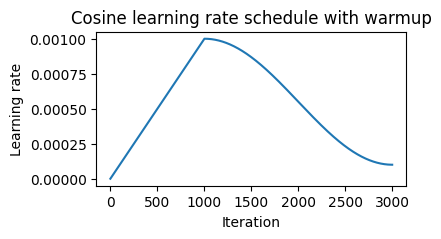

In [ ]:
# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

lr_seq = [get_lr(i) for i in range(max_iters)]
plt.figure(figsize=(4, 2))
plt.plot(lr_seq)
plt.title('Cosine learning rate schedule with warmup')
plt.xlabel('Iteration')
plt.ylabel('Learning rate')
plt.show()

For more details you can read [this post](https://www.borealisai.com/research-blogs/tutorial-17-transformers-iii-training/#Why_are_these_tricks_required).

Here we define our model, optimizer, and run our training:

In [ ]:
# We define the model
model = GPT(n_layer, n_embd, n_head, block_size, vocab_size, dropout)
model.to(device)
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# training loop
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
iter_num = 0 # number of iterations in the lifetime of this process
while True:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    # evaluate the loss on train/val sets
    if iter_num % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        start = " "
        start_ids = encode(start)
        x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
        # run generation
        model.eval()
        try:
            with torch.no_grad():
                y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        except Exception as e:
            pass # If you haven't implemented the generate code
        model.train()
        print('-' * 100)
        print("Example generated:")
        print('-' * 100)
        print(decode(y[0].tolist()))
        print('-' * 100)
    logits, loss = model(X, Y)
    X, Y = get_batch('train')
    # clip the gradient
    if grad_clip != 0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0:
        lossf = loss.item() # loss as float. note: this is a CPU-GPU sync point
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms")
    iter_num += 1
    # termination conditions
    if iter_num > max_iters:
        break

step 0: train loss 4.5104, val loss 4.5103
----------------------------------------------------------------------------------------------------
Example generated:
----------------------------------------------------------------------------------------------------
 loZs7EX
DolLyHJ5(xd!Z)U0CRF_`gc)H:V%jQZ?5A%~Vj&oe8CLq)^5]Q'ihQk}qE]'LOnG=iqm,w6	I?2l'pi rfta~HS~~DP
----------------------------------------------------------------------------------------------------
iter 0: loss 4.5104, time 3479.95ms
iter 10: loss 4.5096, time 193.80ms
iter 20: loss 4.5064, time 194.38ms
iter 30: loss 4.5003, time 192.38ms
iter 40: loss 4.4857, time 193.03ms
iter 50: loss 4.4656, time 194.02ms
iter 60: loss 4.4510, time 196.89ms
iter 70: loss 4.4347, time 196.39ms
iter 80: loss 4.4150, time 194.04ms
iter 90: loss 4.3906, time 196.21ms
step 100: train loss 4.3550, val loss 4.3502
----------------------------------------------------------------------------------------------------
Example generated:
--------

## With key-value caching

In [ ]:
class GPT(nn.Module):

    def __init__(self, n_layer, n_embd, n_head, block_size, vocab_size, dropout):
        super().__init__()
        self.block_size = block_size
        # Initialize transformer components
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, n_embd), # Word token embeddings
            wpe = nn.Embedding(block_size, n_embd), # Positional embeddings
            drop = nn.Dropout(dropout),             # Dropout layer
            h = nn.ModuleList([Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)]),  # Transformer blocks
            ln_f = nn.LayerNorm(n_embd),            # Layer normalization
        ))
        # The output head for language model prediction
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)

        # Initialize weights of the model
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Initializes weights of the model.

        Args:
            module (nn.Module): A module of the neural network.
        """
        if isinstance(module, nn.Linear) or isinstance(module, nn.LayerNorm):
            # Initialize linear and normalization layers
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            # Initialize embeddings
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        """
        Forward pass through the GPT model.

        Args:
            idx (torch.Tensor): Input token indices.
            targets (torch.Tensor, optional): Target token indices for training.

        Returns:
            tuple: A tuple containing the logits and, if provided, the loss.
        """
        device = idx.device
        b, t = idx.size()
        # Ensure input length is within the block size
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        # Compute token and position embeddings
        tok_emb = self.transformer.wte(idx)  # Token embeddings
        pos = torch.arange(t, device=device)  # Position indices
        pos_emb = self.transformer.wpe(pos)[None, :, :]  # Position embeddings
        x = self.transformer.drop(tok_emb + pos_emb)  # Sum and apply dropout

        # Pass through each transformer block
        for block in self.transformer.h:
            x = block(x)

        # Apply final layer normalization
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            # Compute logits and loss if targets are provided
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):

      cache = [None] * len(self.transformer.h)  # Initialize cache for each layer

      for _ in range(max_new_tokens):
          # Prepare the token embeddings and positional encodings
          x = self.transformer.wte(idx)  # Token embeddings
          pos = torch.arange(idx.size(-1), device=idx.device)  # Positional encodings
          x = x + self.transformer.wpe(pos)[None, :, :]  # Add token and position embeddings
          x = self.transformer.drop(x)

          # Pass through each transformer block with caching
          for i, block in enumerate(self.transformer.h):
              x_attn = block.ln_1(x)
              x_attn, present = block.attn(x_attn, layer_past=cache[i])
              cache[i] = present  # Update the cache with the current key-value pairs
              x = x_attn + x  # Apply attention and add residual
              x = block.ln_2(x)
              x = block.mlp(x) + x  # Apply MLP and add residual

              x = self.transformer.ln_f(x)

          # Compute logits and apply temperature
          logits = self.lm_head(x)[:, -1, :] / temperature

          # Optionally crop logits to only the top k options
          if top_k is not None:
              top_logits, top_indices = torch.topk(logits, top_k)
              probs = F.softmax(top_logits, dim=-1)
              idx_next = torch.multinomial(probs, num_samples=1)
              idx_next = torch.gather(top_indices, -1, idx_next)
          else:
              probs = F.softmax(logits, dim=-1)
              idx_next = torch.multinomial(probs, num_samples=1)

            # Append sampled index to the running sequence and continue
          idx = torch.cat([idx, idx_next], dim=1)

            # If the sequence context is growing too long, crop it at block_size
          if idx.size(1) > self.block_size:
              idx = idx[:, -self.block_size:]

      return idx

### **Discussion**

**Key-Value Caching Implimentation**

1. I used a loop to iterate over each transformer block in the model. The self.transformer.h contains a list of transformer blocks (Block instances) in the model.

2. I used layer normalization and attention by first normalizing the input x using layer normalization (ln_1). Then, I applied the attention mechanism using the attn method of the block. The layer_past parameter is used to provide the model with cached key-value pairs from the previous time step.

3. I updated the cache by storing the present variable, which contains the updated key-value pairs computed during the current time step. It is then stored in the cache list at the corresponding position i. This updated cache will be used in the next iteration, providing the model with information about previously seen tokens.

4. I established a residual connection and applied layer normalization by adding the output of the attention mechanism to the original input x. After that, I applied layer normalization (ln_2).

5. I applied the Multi-Layer Perceptron (MLP) and established a residual connection by adding its output to the previous state.

6. I applied the final layer normalization to the output of the last transformer block.


### Training

In [ ]:
# We define the model
model = GPT(n_layer, n_embd, n_head, block_size, vocab_size, dropout)
model.to(device)
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
print(device)

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# training loop
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
iter_num = 0 # number of iterations in the lifetime of this process
while True:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    # evaluate the loss on train/val sets
    if iter_num % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        start = " "
        start_ids = encode(start)
        x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
        # run generation
        model.eval()
        try:
            with torch.no_grad():
                y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        except Exception as e:
            pass # If you haven't implemented the generate code
        model.train()
        print('-' * 100)
        print("Example generated:")
        print('-' * 100)
        print(decode(y[0].tolist()))
        print('-' * 100)
    logits, loss = model(X, Y)
    X, Y = get_batch('train')
    # clip the gradient
    if grad_clip != 0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0:
        lossf = loss.item() # loss as float. note: this is a CPU-GPU sync point
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms")
    iter_num += 1
    # termination conditions
    if iter_num > max_iters:
        break

cuda
step 0: train loss 4.5110, val loss 4.5111
----------------------------------------------------------------------------------------------------
Example generated:
----------------------------------------------------------------------------------------------------
 there and ham see much, and this feen He whe'ltt teel and it his fel ame. "Fror withat walking."
"Yo
----------------------------------------------------------------------------------------------------
iter 0: loss 4.5110, time 1516.65ms
iter 10: loss 4.5102, time 210.10ms
iter 20: loss 4.5073, time 209.26ms
iter 30: loss 4.5016, time 210.67ms
iter 40: loss 4.4884, time 211.05ms
iter 50: loss 4.4703, time 212.30ms
iter 60: loss 4.4551, time 212.53ms
iter 70: loss 4.4389, time 215.33ms
iter 80: loss 4.4187, time 216.17ms
iter 90: loss 4.3920, time 217.67ms
step 100: train loss 4.3562, val loss 4.3527
----------------------------------------------------------------------------------------------------
Example generated:
---

### Subword toknizer

In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.1 MB/s eta 0:00:00


In [ ]:
data_dir = "/content/drive/MyDrive/data_lab2"

for i in range(4):
    input_file_path = f"{data_dir}/hp{i + 1}.txt"
    with open(input_file_path, 'r', encoding='latin-1') as f:
        book = f.read()
    data += book + "\n"

with open("combined_books.txt", "w", encoding="utf-8") as f:
    f.write(data)

In [ ]:
import sentencepiece as spm

spm.SentencePieceTrainer.train(input='combined_books.txt', model_prefix='model_sub', vocab_size=2000)

In [ ]:
sp = spm.SentencePieceProcessor()
sp.load('model_sub.model')

def encode_sub(text):
    return sp.encode_as_ids(text)

def decode_sub(tokens):
    return sp.decode_ids(tokens)

In [ ]:
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids_sub = encode_sub(train_data)
val_ids_sub = encode_sub(val_data)
train_data_sub = np.array(train_ids_sub, dtype=np.uint16)
val_data_sub = np.array(val_ids_sub, dtype=np.uint16)
print(f"train has {len(train_ids_sub):,} tokens")
print(f"val has {len(val_ids_sub):,} tokens")

train has 1,388,172 tokens
val has 152,999 tokens


In [ ]:
CUDA = True
device = "cuda" if CUDA else "cpu"
# data
batch_size = 32
block_size = 256
# model
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2
# adamw optimizer
learning_rate = 1e-3 # max learning rate
max_iters = 3000 # total number of training iterations
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
warmup_iters = 1000 # how many steps to warm up for
lr_decay_iters = max_iters
min_lr = 1e-4
# logging
eval_interval = 100
eval_iters = 10
log_interval = 10
# generation
max_new_tokens = 100
temperature = 0.8
top_k = 40

In [ ]:
def get_batch(split):
    ids = train_ids_sub if split == 'train' else val_ids_sub  # Use the encoded integer arrays
    ix = torch.randint(len(ids) - block_size, (batch_size,))
    x = torch.stack([torch.tensor(ids[i:i+block_size], dtype=torch.long) for i in ix])
    y = torch.stack([torch.tensor(ids[i+1:i+block_size+1], dtype=torch.long) for i in ix])
    if device == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [ ]:
model_sub = GPT(n_layer, n_embd, n_head, block_size, vocab_size=2000, dropout=dropout)
model_sub.to(device)
# optimizer
optimizer_sub = torch.optim.AdamW(model_sub.parameters(), lr=learning_rate)
@torch.no_grad()
def estimate_loss():
    out = {}
    model_sub.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model_sub(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model_sub.train()
    return out

X_sub, Y_sub = get_batch('train') # fetch the very first batch
t0 = time.time()
iter_num = 0 # number of iterations in the lifetime of this process
while True:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num)
    for param_group in optimizer_sub.param_groups:
        param_group['lr'] = lr
    # evaluate the loss on train/val sets
    if iter_num % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        start = "Harry looked around and said,"
        start_ids = encode_sub(start)
        x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
        # run generation
        model_sub.eval()
        try:
            with torch.no_grad():
                y = model_sub.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        except Exception as e:
            pass # If you haven't implemented the generate code
        model_sub.train()
        print('-' * 100)
        print("Example generated:")
        print('-' * 100)
        # print(y[0].tolist())
        print(decode_sub(y[0].tolist()))
        print('-' * 100)
    logits, loss = model_sub(X_sub, Y_sub)
    X_sub, Y_sub = get_batch('train')
    # clip the gradient
    if grad_clip != 0.0:
        torch.nn.utils.clip_grad_norm_(model_sub.parameters(), grad_clip)
    # Backward pass and optimization
    optimizer_sub.zero_grad()
    loss.backward()
    optimizer_sub.step()
    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0:
        lossf = loss.item() # loss as float. note: this is a CPU-GPU sync point
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms")
    iter_num += 1
    # termination conditions
    if iter_num > max_iters:
        break

step 0: train loss 7.6011, val loss 7.6012
----------------------------------------------------------------------------------------------------
Example generated:
----------------------------------------------------------------------------------------------------
backb were have werere from Hermionebre mell were were me -- outb are from Hermione backb allllin were were fromm were notb were " but back back back were were butre from Hermione all backb allllin were butre me were of.y haveve have not all backbre back notre but her all from - of.. forve
----------------------------------------------------------------------------------------------------
iter 0: loss 7.6012, time 1532.92ms
iter 10: loss 7.6011, time 222.67ms
iter 20: loss 7.6000, time 220.49ms
iter 30: loss 7.5989, time 221.65ms
iter 40: loss 7.5964, time 223.75ms
iter 50: loss 7.5888, time 221.77ms
iter 60: loss 7.5773, time 222.17ms
iter 70: loss 7.5652, time 221.90ms
iter 80: loss 7.5494, time 222.88ms
iter 90: loss 7.5286

###Grammer check

Now we will assess the English knowledge of our trained model (Task 3). We load the pairs of words and sentences and print some examples:

In [ ]:
with open("/content/drive/MyDrive/data_lab2/wuggy.txt", 'r') as f:
    spelling_samples = [sample[:-1].split(',') for sample in f]
with open("/content/drive/MyDrive/data_lab2/blimp.txt", 'r') as f:
    grammar_test_samples = [sample[:-1].split(',') for sample in f]
print(spelling_samples[0])
print(grammar_test_samples[0])

['objectivity', 'osbrectifity']
["Harry hadn't attacked himself", "Harry hadn't attacked herself"]


In [ ]:
def get_sample_prob(X):
    #
    # TODO TASK 3
    #
    # Compute the probability of sequence X
    #
    model.eval()
    with torch.no_grad():
        logits, _ = model(X.unsqueeze(0))
        probabilities = F.softmax(logits[:, -1, :], dim=-1)
        prob_sequence = probabilities[0, X[-1].item()].item()
    return prob_sequence

spelling_scores = []
for sample in tqdm(spelling_samples):
    word, non_word = sample
    tokenized_word = encode(word)
    prob_word = get_sample_prob(torch.tensor(tokenized_word).to(device))
    tokenized_non_word = encode(non_word)
    prob_non_word = get_sample_prob(torch.tensor(tokenized_non_word).to(device))
    spelling_scores.append(1.0 * (prob_word > prob_non_word))
print("Spelling score: ", np.mean(spelling_scores))

grammar_scores = []
for sample in tqdm(grammar_test_samples):
    sentence, non_sentence = sample
    tokenized_sentence = encode(sentence)
    prob_sentence = get_sample_prob(torch.tensor(tokenized_sentence).to(device))
    tokenized_non_sentence = encode(non_sentence)
    prob_non_sentence = get_sample_prob(torch.tensor(tokenized_non_sentence).to(device))
    grammar_scores.append(1.0 * (prob_sentence > prob_non_sentence))
print("Grammar score: ", np.mean(grammar_scores))

  0%|          | 0/40000 [00:00<?, ?it/s]

Spelling score:  0.5039


  0%|          | 0/500 [00:00<?, ?it/s]

Grammar score:  0.398


## **Discussion**

**TASK 3**

**Computing the probability of sequence x**

- Model Evaluation:

The model is set to evaluation mode using model.eval().

- Forward Pass:

The input sequence X is passed through the model using model(X.unsqueeze(0)).

X.unsqueeze(0) is used to add a batch dimension, as models typically expect inputs in batch form.

- Logits Extraction:

The output of the model is a sequence of logits, representing the unnormalized probabilities for each token in the vocabulary.

logits[:, -1, :] extracts the logits corresponding to the last token in the sequence.

- Softmax Function:

The softmax function (F.softmax) is applied to the logits to obtain normalized probabilities.

F.softmax(logits[:, -1, :], dim=-1) computes softmax along the last dimension, ensuring probabilities sum to 1.

- Probability of Last Token:

The probability of the last token in the sequence is extracted.

probabilities[0, X[-1].item()] selects the probability associated with the index of the last token in the sequence.

- Result Extraction:

The final probability value is obtained as a Python float.

prob_sequence = probabilities[0, X[-1].item()].item() extracts the float value of the probability.

- Result Return:

The calculated probability of the last token in the sequence (prob_sequence) is returned.

### English and Grammer check for sub-word toknizer

In [ ]:
def get_sample_prob(X):
    model_sub.eval()
    with torch.no_grad():
        logits, _ = model_sub(X.unsqueeze(0))
        probabilities = F.softmax(logits[:, -1, :], dim=-1)
        prob_sequence = probabilities[0, X[-1].item()].item()
    return prob_sequence

spelling_scores = []
for sample in tqdm(spelling_samples):
    word, non_word = sample
    tokenized_word = encode(word)
    prob_word = get_sample_prob(torch.tensor(tokenized_word).to(device))
    tokenized_non_word = encode(non_word)
    prob_non_word = get_sample_prob(torch.tensor(tokenized_non_word).to(device))
    spelling_scores.append(1.0 * (prob_word > prob_non_word))
print("Spelling score: ", np.mean(spelling_scores))

grammar_scores = []
for sample in tqdm(grammar_test_samples):
    sentence, non_sentence = sample
    tokenized_sentence = encode(sentence)
    prob_sentence = get_sample_prob(torch.tensor(tokenized_sentence).to(device))
    tokenized_non_sentence = encode(non_sentence)
    prob_non_sentence = get_sample_prob(torch.tensor(tokenized_non_sentence).to(device))
    grammar_scores.append(1.0 * (prob_sentence > prob_non_sentence))
print("Grammar score: ", np.mean(grammar_scores))

  0%|          | 0/40000 [00:00<?, ?it/s]

Spelling score:  0.510425


  0%|          | 0/500 [00:00<?, ?it/s]

Grammar score:  0.632


### **Discussion**

The grammar score is calculated based on the probability assigned by the language model to correctly formed sentences and non-grammatical versions.

Data Input:

grammar_test_samples is a list of tuples, each containing a correctly formed sentence (sentence) and a non-grammatical version (non_sentence).
Evaluation Loop:

The code iterates over each sample in grammar_test_samples.
For each sample, it tokenizes the correctly formed sentence and the non-grammatical version using the encode function.
Probability Computation:

It computes the probability of the correctly formed sentence (prob_sentence) and the non-grammatical version (prob_non_sentence) using the get_sample_prob function.
Score Assignment:

A binary score is assigned based on a comparison of probabilities (1 for correct grammar, 0 for incorrect grammar).
The scores are appended to the grammar_scores list.
Average Score Calculation:

The average grammar score is calculated as the mean of the binary scores in the grammar_scores list.

# Problem 3. Vision transformer

Transformers go well beyond text. They have been applied with tremendous success to many modalities (audio, images, video, graphs, etc). However, its application to images can be unintuitive, as we do not tend to think of them as the 1D sequences for which transformers were designed. In this exercise we will implement a vision transformer to illustrate how this works.

We use the classic MNIST dataset and will try to get a vision transformer to do classification of handwritten numbers.

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

100%|██████████| 9912422/9912422 [00:00<00:00, 162640824.18it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 39038251.31it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40476711.46it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 4440682.70it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Let's take a look at one of the samples:

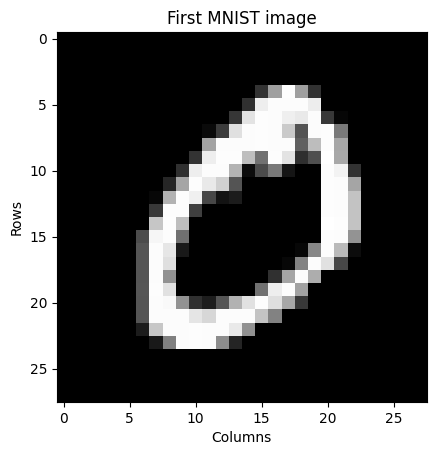

In [ ]:
first_image = np.array(mnist_trainset[1][0])
plt.imshow(first_image, cmap='gray')
plt.title('First MNIST image')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

The way we turn an image into a 1D sequence is pretty straightforward. We can simply flatten it in a row major form. That is, we will turn our 28x28 pixels image into a 784 long sequence, with the first row becoming the first 24 elements, the second row the next, and so on.

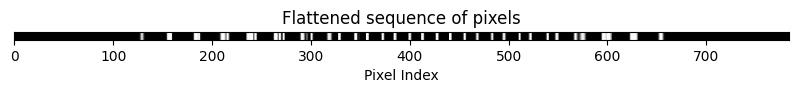

In [ ]:
flattened_image = first_image.reshape(-1)
plt.figure(figsize=(10, 0.1))
plt.imshow([flattened_image], cmap='gray', aspect='auto')
plt.title('Flattened sequence of pixels')
plt.xlabel('Pixel Index')
plt.yticks([])
plt.show()

This should work fine, but there is a technical issue. Remember that transformer's computational cost scales quadratically with the length of the sequence. Notice that our tiny 24x24 pixels image already results in a sequence of length 784. This is ok as long as you have a moderately large GPU and you use a not too large batch size, but in Colab, or in the smallest GPUs in our cluster we might already run into memory issues. Moreover, in most practical applications we will be dealing with much larger images. For a standard HD image of 1024 x 768 pixels we would have a sequence length of 786432! This is already almost 10 times more than what the state-of-the-art models like GPT-4 support.

In practice, instead of working on sequences of pixels, we use sequences of image patches. We will split our image into non-overlapping 4x4 patches:

Text(0.5, 1.0, 'Image with 4x4 Patches')

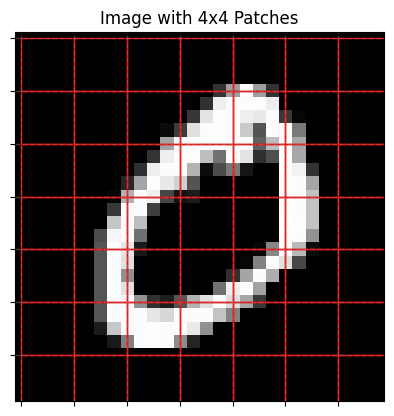

In [ ]:
image_size = first_image.shape[0]
patch_size = 4
fig, ax = plt.subplots()
ax.imshow(first_image, cmap='gray')
for i in range(0, image_size, patch_size):
    for j in range(0, image_size, patch_size):
        rect = Rectangle((j, i), patch_size, patch_size, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
ax.set_xticks(np.arange(0, image_size, patch_size))
ax.set_yticks(np.arange(0, image_size, patch_size))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(True, which='both', linestyle='--', linewidth=1, color='gray', alpha=0.5)
plt.title(f'Image with {patch_size}x{patch_size} Patches')

When we flattened it, it becomes a sequence of 49 patches:

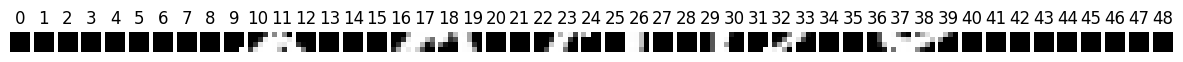

In [ ]:
patch_sequence = []
for i in range(0, image_size, patch_size):
    for j in range(0, image_size, patch_size):
        patch = first_image[i:i+patch_size, j:j+patch_size]
        patch_sequence.append(patch)
num_patches = (image_size // patch_size) ** 2
fig, axs = plt.subplots(1, num_patches, figsize=(15, 2))
for i, patch in enumerate(patch_sequence):
    axs[i].imshow(patch, cmap='gray')
    axs[i].set_title(i)
    axs[i].axis('off')

plt.show()

_Note: in most practical applications we will be dealing with much larger images, so we will need larger patches in order to sufficiently shorten the sequence length._


Finally we transform each patch, a 4x4 matrix, into a vector of 16 elements, which is the input our transformer expects. We simply flatten each patch:

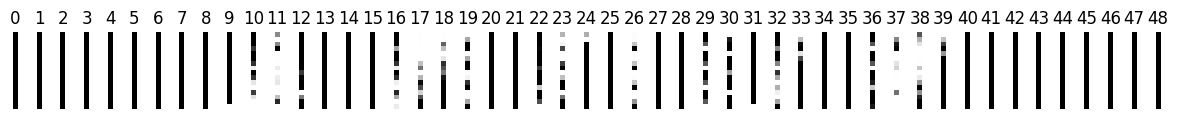

In [ ]:
fig, axs = plt.subplots(1, num_patches, figsize=(15, 1))
for i, patch in enumerate(patch_sequence):
    axs[i].imshow(patch.reshape(-1, 1), cmap='gray')
    axs[i].set_title(i)
    axs[i].axis('off')
plt.show()

We have our inputs ready. Now onto the model. This is the architecture our digit classifier will use:
    
  <div>
        <img src="attachment:image.png" width="500"/>
    </div>

**Tasks**:
1. **(3 pt)** Implement the architecture of the classifier in the class `VisionTransformer` and train it on the MNIST dataset. Note that you can reuse most of the elements that you already implemented for `GPT`. You just need to avoid auto-regressive masking and figure out how to input the patches instead of discrete tokens.
2. **(2 pt)** Implement a simple convolutional network classifier and compare its performnace with the vision transformer.
3. **(4 pt máx)** Implement any of the two methods from the paper [Vision Transformer for Small-Size Datasets](https://arxiv.org/pdf/2112.13492v1.pdf) to try to improve the performance of our model. You can find a Keras tutorial implementing them [here](https://keras.io/examples/vision/vit_small_ds/#implement-locality-self-attention). Each method is worth **2 pt**.

Let's start defining some parameters. As before, it works with these defaults, but you can play with them

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

device = "cuda" if CUDA else "cpu"
# data
batch_size = 32
patch_size = 4
img_w, img_h = np.array(mnist_trainset[1][0]).shape
block_size = img_w // patch_size * img_h // patch_size
# model
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2
input_size = patch_size * patch_size
n_classes = 10 # 10-digit classification
# adamw optimizer
learning_rate = 5e-4 # max learning rate
max_iters = 10000 # total number of training iterations
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
warmup_iters = 1000 # how many steps to warm up for
lr_decay_iters = max_iters
min_lr = 5e-5
# logging
eval_interval = 1000
log_interval = 100

Now we preprocess our dataset to transform every image into patch sequences of shape `(49, patch_size, patch_size)`

In [ ]:
# Transformation to extract patches and flatten them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)),
    transforms.Lambda(lambda x: x.contiguous().view(-1, patch_size, patch_size)),
])

# Apply the transform to the loaded datasets
mnist_trainset.transform = transform
mnist_testset.transform = transform

Here you have to define the model:

In [ ]:
class VisionTransformer(torch.nn.Module):
    def __init__(self, input_size, n_classes, n_layer, n_embd, n_head, block_size, dropout):
        super().__init__()
        self.block_size = block_size
        #
        # TODO TASK 1
        #
        # Define the architecture of the vision transformer as illustrated in the pic above
        #
        # Transformer layers
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Linear(input_size, n_embd),  # Patch embedding
            wpe=nn.Embedding(block_size, n_embd),  # Positional embedding
            drop=nn.Dropout(dropout),
            h=nn.ModuleList([Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)]),
            ln_f=nn.LayerNorm(n_embd),
        ))

        # Classifier head
        self.classifier = nn.Linear(n_embd, n_classes)

        # init all weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.LayerNorm):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets=None):
        device = x.device
        b, t, _ = x.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        # Embed patches and add positional encoding
        #
        # TODO TASK 1
        #
        # Define the forward pass of the vision transformer
        #
        x = self.transformer.wte(x)  # Patch embeddings
        pos = torch.arange(t, device=device)
        x = x + self.transformer.wpe(pos)[None, :, :]  # Add positional embeddings
        x = self.transformer.drop(x)

        # Pass through each transformer block
        for block in self.transformer.h:
            x = block(x)

        # Apply layer norm
        x = self.transformer.ln_f(x)

        # Classifier
        logits = self.classifier(x.mea`11n(dim=1))  # Using mean pooling here
        loss = F.cross_entropy(logits, targets) if targets is not None else None
        return logits, loss

In [ ]:
# Create data loaders
train_loader = DataLoader(dataset=mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=mnist_testset, batch_size=batch_size, shuffle=False)

# Model
model = VisionTransformer(input_size, n_classes, n_layer, n_embd, n_head, block_size, dropout)
model.to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

iter_counter = 0
test_losses_vit = []  # List to store test losses for Vision Transformer

while iter_counter < max_iters:
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        # Flatten the patch
        patch_sequence = data.view(-1, block_size, patch_size * patch_size).to(device)
        target = target.to(device)
        # Forward pass
        logits, loss = model(patch_sequence, target)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Calculate accuracy
        _, predicted = torch.max(logits, -1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        total_loss += loss.item()
        iter_counter += 1

        # Log loss and accuracy
        if iter_counter % log_interval == 0:
            avg_loss = total_loss / log_interval
            accuracy = correct / total
            print(f'Iter [{iter_counter}/{max_iters}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
            total_loss = 0.0
            correct = 0
            total = 0

        # Evaluate test loss
        if iter_counter % eval_interval == 0 or iter_counter == max_iters:
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for test_data, test_target in test_loader:
                    test_patch_sequence = test_data.view(-1, block_size, patch_size * patch_size).to(device)
                    test_target = test_target.to(device)
                    test_outputs, loss = model(test_patch_sequence, test_target)
                    test_loss += loss.item()
                    test_losses_vit.append(loss.item())  # Store each batch's test loss
                    _, test_predicted = torch.max(test_outputs, -1)
                    test_total += test_target.size(0)
                    test_correct += (test_predicted == test_target).sum().item()
            avg_test_loss = test_loss / len(test_loader)
            test_accuracy = test_correct / test_total
            print(f'Iter [{iter_counter}/{max_iters}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')
            model.train()

        if iter_counter == max_iters:
            break

# Now, test_losses_vit contains the test loss for each batch

Iter [100/10000], Batch [100/1875], Loss: 2.2011, Accuracy: 21.56%
Iter [200/10000], Batch [200/1875], Loss: 1.8855, Accuracy: 31.22%
Iter [300/10000], Batch [300/1875], Loss: 1.6973, Accuracy: 36.06%
Iter [400/10000], Batch [400/1875], Loss: 1.5580, Accuracy: 41.25%
Iter [500/10000], Batch [500/1875], Loss: 1.4771, Accuracy: 43.19%
Iter [600/10000], Batch [600/1875], Loss: 1.4335, Accuracy: 47.34%
Iter [700/10000], Batch [700/1875], Loss: 1.3342, Accuracy: 50.78%
Iter [800/10000], Batch [800/1875], Loss: 1.3105, Accuracy: 50.31%
Iter [900/10000], Batch [900/1875], Loss: 1.1556, Accuracy: 56.97%
Iter [1000/10000], Batch [1000/1875], Loss: 1.0657, Accuracy: 59.72%
Iter [1000/10000], Batch [1000/1875], Test Loss: 0.9648, Test Accuracy: 67.39%
Iter [1100/10000], Batch [1100/1875], Loss: 1.0153, Accuracy: 64.22%
Iter [1200/10000], Batch [1200/1875], Loss: 0.9591, Accuracy: 64.31%
Iter [1300/10000], Batch [1300/1875], Loss: 0.9439, Accuracy: 66.72%
Iter [1400/10000], Batch [1400/1875], Loss

### **CNN Implimentation**

In [ ]:
class SimpleCNN(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, n_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)

### **Training and Testion the CNN model**

In [ ]:
def train(model, device, train_loader, optimizer, max_iters, log_interval):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    iter_counter = 0

    while iter_counter < max_iters:
        for batch_idx, (data, target) in enumerate(train_loader):
            if iter_counter >= max_iters:
                break

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.size(0)  # Multiply by batch size for accurate average
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.size(0)
            iter_counter += 1

            if iter_counter % log_interval == 0:
                avg_loss = total_loss / total  # Average loss across all processed batches
                accuracy = 100. * correct / total
                print(f'Iteration: {iter_counter}/{max_iters}, Loss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%')
                total_loss = 0
                correct = 0
                total = 0


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

### **Compare CNN and Vision transformer**

In [ ]:
total_samples = len(mnist_trainset)

num_batches_per_epoch = total_samples / batch_size
num_epochs = int(round(max_iters / num_batches_per_epoch))

In [ ]:
# Instantiate models
cnn_model = SimpleCNN(n_classes).to(device)
# vit_model = VisionTransformer(input_size, n_classes, n_layer, n_embd, n_head, block_size, dropout).to(device)

# Optimizers
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [ ]:
# Transformation for the Vision Transformer (Re writing as written above, just to avoid confusion)
# transform_vit = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: x.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)),
#     transforms.Lambda(lambda x: x.contiguous().view(-1, patch_size * patch_size)),
# ])

# Transformation for the Simple CNN (standard image format)
transform_cnn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalizing with MNIST mean and std
])

# Loading datasets with appropriate transformations
# mnist_trainset_vit = datasets.MNIST(root='./data', train=True, download=True, transform=transform_vit)
# mnist_testset_vit = datasets.MNIST(root='./data', train=False, download=True, transform=transform_vit)

mnist_trainset_cnn = datasets.MNIST(root='./data', train=True, download=True, transform=transform_cnn)
mnist_testset_cnn = datasets.MNIST(root='./data', train=False, download=True, transform=transform_cnn)

# Data loaders for each model
# train_loader_vit = DataLoader(mnist_trainset_vit, batch_size=batch_size, shuffle=True)
# test_loader_vit = DataLoader(mnist_testset_vit, batch_size=batch_size, shuffle=False)

train_loader_cnn = DataLoader(mnist_trainset_cnn, batch_size=batch_size, shuffle=True)
test_loader_cnn = DataLoader(mnist_testset_cnn, batch_size=batch_size, shuffle=False)

# Ensure to define and initialize your models (cnn_model and vit_model) and optimizers (optimizer_cnn and optimizer_vit) here

# Training and evaluation loop
# for epoch in range(1, num_epochs + 1):
    # Training and testing the CNN
train(cnn_model, device, train_loader_cnn, optimizer_cnn, max_iters, log_interval=100)
test(cnn_model, device, test_loader_cnn)

Iteration: 100/10000, Loss: 0.688017, Accuracy: 78.66%
Iteration: 200/10000, Loss: 0.234817, Accuracy: 92.59%
Iteration: 300/10000, Loss: 0.169122, Accuracy: 95.00%
Iteration: 400/10000, Loss: 0.134197, Accuracy: 95.81%
Iteration: 500/10000, Loss: 0.127421, Accuracy: 96.25%
Iteration: 600/10000, Loss: 0.118654, Accuracy: 96.69%
Iteration: 700/10000, Loss: 0.109682, Accuracy: 96.41%
Iteration: 800/10000, Loss: 0.089184, Accuracy: 97.28%
Iteration: 900/10000, Loss: 0.090536, Accuracy: 97.38%
Iteration: 1000/10000, Loss: 0.091052, Accuracy: 97.56%
Iteration: 1100/10000, Loss: 0.087153, Accuracy: 97.34%
Iteration: 1200/10000, Loss: 0.077074, Accuracy: 97.47%
Iteration: 1300/10000, Loss: 0.069610, Accuracy: 98.03%
Iteration: 1400/10000, Loss: 0.055999, Accuracy: 98.03%
Iteration: 1500/10000, Loss: 0.073393, Accuracy: 97.75%
Iteration: 1600/10000, Loss: 0.063769, Accuracy: 97.84%
Iteration: 1700/10000, Loss: 0.055878, Accuracy: 98.12%
Iteration: 1800/10000, Loss: 0.082783, Accuracy: 97.56%
I

In [ ]:
def evaluate_model(model, device, test_loader):
    model.eval()
    test_losses = []
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Handle Vision Transformer output
            if isinstance(model, VisionTransformer):
                # Assuming the Vision Transformer model returns logits and loss
                data = data.view(-1, block_size, patch_size * patch_size)  # Flatten patches for Vision Transformer
                logits, _ = model(data, target)
                outputs = F.log_softmax(logits, dim=1)
            else:
                # Handle CNN and other model outputs
                outputs = model(data)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]  # Assuming the first element is the logits for models that return a tuple

            loss = F.nll_loss(outputs, target, reduction='sum').item()
            test_losses.append(loss)
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    average_loss = sum(test_losses) / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_losses, average_loss, accuracy


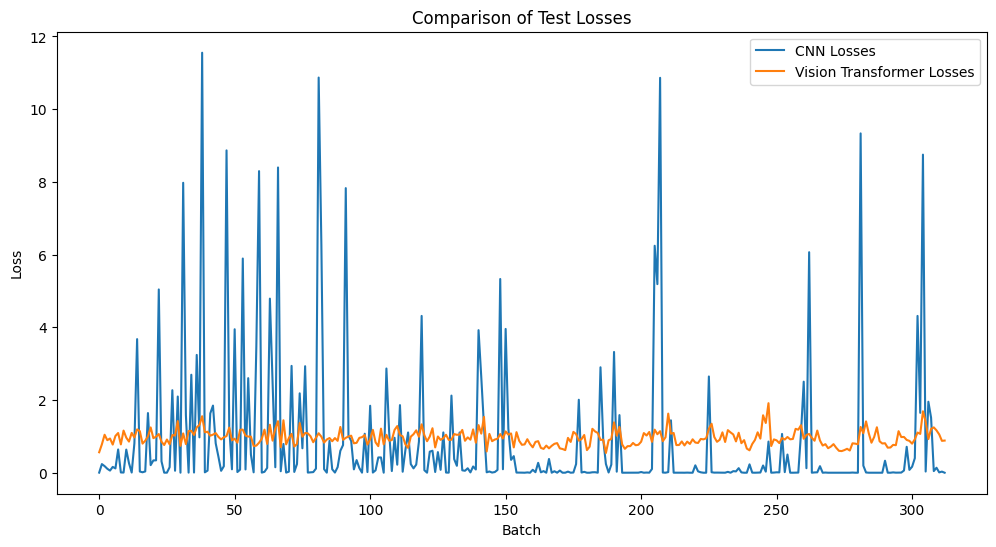

In [ ]:
# Evaluate the CNN
test_losses_cnn, avg_loss_cnn, accuracy_cnn = evaluate_model(cnn_model, device, test_loader_cnn)

plt.figure(figsize=(12, 6))
plt.plot(test_losses_cnn, label='CNN Losses')
plt.plot(test_losses_vit[:len(test_losses_cnn)], label='Vision Transformer Losses')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Comparison of Test Losses')
plt.legend()
plt.show()

### **LSA**

In [ ]:
class LocalSelfAttention(nn.Module):
    """
    A PyTorch module for local self-attention.

    This module implements a self-attention mechanism where each token attends only to
    a local neighborhood defined by a window size. This can be particularly useful for
    tasks where local context is more relevant than global context.

    Attributes:
        heads (int): The number of attention heads.
        scale (float): The scale factor for query normalization.
        to_qkv (nn.Linear): Linear transformation for query, key, and value.
        to_out (nn.Linear): Linear transformation for the output.
        window_size (int): The size of the local window for attention.
        mask_cache (dict): A cache for masks based on sequence length.
    """
    def __init__(self, dim, heads, window_size, temperature):
        """
        Initializes the LocalSelfAttention module.

        Args:
            dim (int): The dimensionality of the input and output.
            heads (int): The number of attention heads.
            window_size (int): The size of the local window for attention.
            temperature (float): A scaling factor for attention scores.
        """
        super().__init__()
        self.heads = heads
        self.scale = temperature / dim ** 0.5

        # Linear transformations for query, key, and value
        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        # Linear transformation for the output
        self.to_out = nn.Linear(dim, dim)

        self.window_size = window_size
        self.mask_cache = {}

    def forward(self, x):
        """
        The forward pass for the LocalSelfAttention module.

        Args:
            x (torch.Tensor): The input tensor of shape (batch size, sequence length, dimension).

        Returns:
            torch.Tensor: The output tensor after applying local self-attention.
        """
        device = x.device
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.reshape(b, n, h, -1).transpose(1, 2), qkv)

        q = q * self.scale

        attn = (q @ k.transpose(-2, -1))
        attn = attn.masked_fill(self.mask(n, device) == 0, float('-inf'))
        attn = attn.softmax(dim=-1)

        out = (attn @ v).transpose(1, 2).reshape(b, n, -1)
        out = self.to_out(out)
        return out

    def mask(self, n, device):
        """
        Generates a mask for local attention.

        Args:
            n (int): The sequence length.
            device (torch.device): The device on which the mask is to be generated.

        Returns:
            torch.Tensor: A mask tensor for local self-attention.
        """
        if n not in self.mask_cache:
            idx = torch.arange(n, device=device)
            self.mask_cache[n] = (torch.abs(idx[None, :] - idx[:, None]) < self.window_size).int()
        return self.mask_cache[n]

In [ ]:
class Block(nn.Module):
    """
    A transformer block with local self-attention and a feed-forward neural network.

    This block is part of a transformer-style architecture. It incorporates local self-attention,
    which allows the model to focus on local context within a specified window size, and a
    feed-forward neural network for additional processing of the attention output.

    Attributes:
        ln1 (nn.LayerNorm): Layer normalization before the attention mechanism.
        attn (LocalSelfAttention): The local self-attention mechanism.
        ln2 (nn.LayerNorm): Layer normalization before the feed-forward network.
        mlp (nn.Sequential): A feed-forward neural network.
    """
    def __init__(self, n_embd, n_head, block_size, dropout, window_size, temperature):
        """
        Initializes the Block module.

        Args:
            n_embd (int): The size of the input and output embeddings.
            n_head (int): The number of attention heads in the local self-attention mechanism.
            block_size (int): The size of each block of input data.
            dropout (float): The dropout rate for the feed-forward network.
            window_size (int): The window size for the local self-attention mechanism.
            temperature (float): The temperature parameter for scaling attention scores.
        """
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd) # Layer normalization
        self.attn = LocalSelfAttention(n_embd, n_head, window_size, temperature)  # Local self-attention
        self.ln2 = nn.LayerNorm(n_embd) # Layer normalization
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # First linear layer
            nn.GELU(),  # GELU activation function
            nn.Linear(4 * n_embd, n_embd),  # Second linear layer
            nn.Dropout(dropout),  # Dropout layer
        )

    def forward(self, x):
        """
        Forward pass of the Block module.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after processing by the block.
        """
        # Apply local self-attention and add the input (residual connection)
        x = x + self.attn(self.ln1(x))
        # Apply the feed-forward network and add the result (residual connection)
        x = x + self.mlp(self.ln2(x))
        return x

In [ ]:
window_size = 6
temperature = 1.0

In [ ]:
class VisionTransformer(torch.nn.Module):
    """
    A Vision Transformer (ViT) model for image classification tasks.

    This implementation of ViT uses local self-attention blocks, allowing the model to focus on local features
    within a specified window size. It includes a sequence of transformer blocks, each comprising a local self-attention
    mechanism and a feed-forward neural network.

    Attributes:
        block_size (int): The number of patches in a sequence.
        transformer (nn.ModuleDict): A dictionary containing the transformer components.
        classifier (nn.Linear): The classification head of the model.
    """
    def __init__(self, input_size, n_classes, n_layer, n_embd, n_head, block_size, dropout, window_size, temperature):
        """
        Initializes the VisionTransformer module.

        Args:
            input_size (int): The size of each input patch.
            n_classes (int): The number of classes for classification.
            n_layer (int): The number of transformer blocks.
            n_embd (int): The embedding dimension.
            n_head (int): The number of heads in the local self-attention mechanism.
            block_size (int): The number of patches in a sequence.
            dropout (float): The dropout rate.
            window_size (int): The window size for local self-attention.
            temperature (float): The temperature parameter for scaling attention scores.
        """
        super().__init__()
        self.block_size = block_size

        # Initialize transformer components
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Linear(input_size, n_embd),  # Patch embedding
            wpe=nn.Embedding(block_size, n_embd),  # Positional embedding
            drop=nn.Dropout(dropout), # Dropout layer
            h=nn.ModuleList([Block(n_embd, n_head, block_size, dropout, window_size, temperature) for _ in range(n_layer)]),
            ln_f=nn.LayerNorm(n_embd),  # Layer normalization
        ))

        # Classifier head
        self.classifier = nn.Linear(n_embd, n_classes)

        # init all weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Initializes weights of the model.

        Args:
            module (nn.Module): A module of the neural network.
        """
        if isinstance(module, nn.Linear) or isinstance(module, nn.LayerNorm):
            # Initialize linear and layer normalization layers
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            # Initialize embedding layers
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets=None):
        """
        Forward pass of the VisionTransformer.

        Args:
            x (torch.Tensor): The input tensor containing image patches.
            targets (torch.Tensor, optional): The target labels for classification.

        Returns:
            tuple: A tuple containing the logits and, if provided, the loss.
        """
        device = x.device
        b, t, _ = x.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        # Embed patches and add positional encoding
        x = self.transformer.wte(x)  # Patch embeddings
        pos = torch.arange(t, device=device)  # Position indices
        x = x + self.transformer.wpe(pos)[None, :, :]  # Add positional embeddings
        x = self.transformer.drop(x)  # Apply dropout

        # Pass through each transformer block
        for block in self.transformer.h:
            x = block(x)

        # Apply layer normalization
        x = self.transformer.ln_f(x)

        # Classifier
        logits = self.classifier(x.mean(dim=1))  # Using mean pooling here
        loss = F.cross_entropy(logits, targets) if targets is not None else None
        return logits, loss

In [ ]:
# Create data loaders
print(device)
train_loader = DataLoader(dataset=mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=mnist_testset, batch_size=batch_size, shuffle=False)

# Model
model = VisionTransformer(input_size, n_classes, n_layer, n_embd, n_head, block_size, dropout, window_size, temperature)
model.to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

iter_counter = 0
test_losses_vit2 = []  # List to store test losses for Vision Transformer
accuracy_vit2 = []

while iter_counter < max_iters:
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        # Flatten the patch
        patch_sequence = data.view(-1, block_size, patch_size * patch_size).to(device)
        target = target.to(device)
        # Forward pass
        logits, loss = model(patch_sequence, target)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Calculate accuracy
        _, predicted = torch.max(logits, -1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        total_loss += loss.item()
        iter_counter += 1

        # Log loss and accuracy
        if iter_counter % log_interval == 0:
            avg_loss = total_loss / log_interval
            accuracy = correct / total
            print(f'Iter [{iter_counter}/{max_iters}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
            total_loss = 0.0
            correct = 0
            total = 0

        # Evaluate test loss
        if iter_counter % eval_interval == 0 or iter_counter == max_iters:
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for test_data, test_target in test_loader:
                    test_patch_sequence = test_data.view(-1, block_size, patch_size * patch_size).to(device)
                    test_target = test_target.to(device)
                    test_outputs, loss = model(test_patch_sequence, test_target)
                    test_loss += loss.item()
                    test_losses_vit2.append(loss.item())  # Store each batch's test loss
                    _, test_predicted = torch.max(test_outputs, -1)
                    test_total += test_target.size(0)
                    test_correct += (test_predicted == test_target).sum().item()
            avg_test_loss = test_loss / len(test_loader)
            test_accuracy = test_correct / test_total
            accuracy_vit2.append(test_accuracy)
            # test_losses_vit2.append(avg_test_loss)
            print(f'Iter [{iter_counter}/{max_iters}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')
            model.train()

        if iter_counter == max_iters:
            break

cuda
Iter [100/10000], Batch [100/1875], Loss: 2.2406, Accuracy: 17.97%
Iter [200/10000], Batch [200/1875], Loss: 1.9920, Accuracy: 22.56%
Iter [300/10000], Batch [300/1875], Loss: 1.8393, Accuracy: 28.88%
Iter [400/10000], Batch [400/1875], Loss: 1.8400, Accuracy: 28.41%
Iter [500/10000], Batch [500/1875], Loss: 1.7239, Accuracy: 31.03%
Iter [600/10000], Batch [600/1875], Loss: 1.7457, Accuracy: 29.59%
Iter [700/10000], Batch [700/1875], Loss: 1.7835, Accuracy: 30.34%
Iter [800/10000], Batch [800/1875], Loss: 1.7653, Accuracy: 33.44%
Iter [900/10000], Batch [900/1875], Loss: 1.7447, Accuracy: 30.69%
Iter [1000/10000], Batch [1000/1875], Loss: 1.6890, Accuracy: 35.03%
Iter [1000/10000], Batch [1000/1875], Test Loss: 1.7122, Test Accuracy: 29.95%
Iter [1100/10000], Batch [1100/1875], Loss: 1.7163, Accuracy: 33.62%
Iter [1200/10000], Batch [1200/1875], Loss: 1.7381, Accuracy: 34.31%
Iter [1300/10000], Batch [1300/1875], Loss: 1.7516, Accuracy: 30.72%
Iter [1400/10000], Batch [1400/1875],

### **STP**

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

device = "cuda" if CUDA else "cpu"
# data
batch_size = 32
patch_size = 4
img_w, img_h = np.array(mnist_trainset[1][0]).shape
block_size = img_w // patch_size * img_h // patch_size
# model
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2
input_size = patch_size * patch_size
n_classes = 10 # 10-digit classification
# adamw optimizer
learning_rate = 5e-4 # max learning rate
max_iters = 10000 # total number of training iterations
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
warmup_iters = 1000 # how many steps to warm up for
lr_decay_iters = max_iters
min_lr = 5e-5
# logging
eval_interval = 1000
log_interval = 100

In [ ]:
# Transformation to extract patches and flatten them
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Lambda(lambda x: x.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)), # Extract patches
    transforms.Lambda(lambda x: x.contiguous().view(-1, patch_size, patch_size)), # Flatten the patches
])

# Apply the transform to the loaded datasets
mnist_trainset.transform = transform  # Apply the transform to the training dataset
mnist_testset.transform = transform # Apply the transform to the test dataset

In [ ]:
class Block(nn.Module):
    """
    Transformer Block.

    Args:
        n_embd (int): Dimension of the input embeddings.
        n_head (int): Number of attention heads.
        block_size (int): Size of the blocks.
        dropout (float): Dropout probability.

    Attributes:
        ln_1 (nn.LayerNorm): Layer normalization for the first sub-layer.
        attn (MultiheadAttention): Multi-head self-attention layer.
        ln_2 (nn.LayerNorm): Layer normalization for the second sub-layer.
        mlp (MLP): Multi-layer perceptron for feedforward processing.

    """

    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd)
        self.attn = MultiheadAttention(n_embd, n_head, block_size, dropout)
        self.ln_2 = nn.LayerNorm(n_embd)
        self.mlp = MLP(n_embd, dropout)

    def forward(self, x):
        """
        Forward pass through the Transformer Block.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output tensor after passing through the block.

        """
        # Apply layer normalization to the input
        x_attn = self.ln_1(x)
        # Apply multi-head self-attention and add the residual connection
        x_attn = self.attn(x_attn) + x  # Apply attention and add residual
        # Apply layer normalization to the result of the attention
        x = self.ln_2(x_attn)
        # Apply the feedforward MLP and add the residual connection
        x = self.mlp(x) + x_attn  # Apply MLP and add residual
        return x

In [ ]:
class ShiftedPatchDataset(torch.utils.data.Dataset):
    """
    Dataset for creating shifted patches from an MNIST dataset.

    Args:
        mnist_dataset (torch.utils.data.Dataset): Original MNIST dataset.

    Attributes:
        mnist_dataset (torch.utils.data.Dataset): Original MNIST dataset.

    """
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        """
        Get the number of samples in the dataset.

        Returns:
            int: Number of samples in the dataset.

        """
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            Tuple[torch.Tensor, int]: A tuple containing a tensor of shifted images and the corresponding label.

        """
        # Retrieve the original image and label from the MNIST dataset
        image, label = self.mnist_dataset[idx]
        image = np.array(image)

        # Shift the image in four directions: up, down, left, and right
        up = np.roll(image, -1, axis=0)
        down = np.roll(image, 1, axis=0)
        left = np.roll(image, -1, axis=1)
        right = np.roll(image, 1, axis=1)

        # Stack the shifted images and add a channel dimension
        stacked_images = np.stack([image, up, down, left, right], axis=0)

        # Convert the stacked images to a torch tensor of float32 dtype
        return torch.tensor(stacked_images, dtype=torch.float32), label

In [ ]:
# Initialize the shifted patch dataset
shifted_trainset = ShiftedPatchDataset(mnist_trainset)
shifted_testset = ShiftedPatchDataset(mnist_testset)

# Create data loaders with the shifted dataset
train_loader = DataLoader(dataset=shifted_trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=shifted_testset, batch_size=batch_size, shuffle=False)

In [ ]:
class VisionTransformer(torch.nn.Module):
    """
    Vision Transformer model for image classification.

    Args:
        input_size (int): Input feature dimension (e.g., number of flattened patches).
        n_classes (int): Number of output classes.
        n_layer (int): Number of transformer layers.
        n_embd (int): Dimension of the embedding layer.
        n_head (int): Number of attention heads.
        block_size (int): Block size for positional embeddings.
        dropout (float): Dropout probability.

    Attributes:
        block_size (int): Block size for positional embeddings.
        transformer (nn.ModuleDict): Transformer layers including patch embedding, positional embedding, transformer blocks, and layer normalization.
        classifier (nn.Linear): Linear layer for classification.

    """
    def __init__(self, input_size, n_classes, n_layer, n_embd, n_head, block_size, dropout):
        super().__init__()
        self.block_size = block_size

        # Transformer layers
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Linear(input_size, n_embd),  # Patch embedding
            wpe=nn.Embedding(block_size, n_embd),  # Positional embedding
            drop=nn.Dropout(dropout),
            h=nn.ModuleList([Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)]),
            ln_f=nn.LayerNorm(n_embd),
        ))

        # Classifier head
        self.classifier = nn.Linear(n_embd, n_classes)

        # init all weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Initialize weights of the model.

        Args:
            module (nn.Module): Module for weight initialization.

        """
        if isinstance(module, nn.Linear) or isinstance(module, nn.LayerNorm):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets=None):
        """
        Forward pass of the Vision Transformer model.

        Args:
            x (torch.Tensor): Input tensor representing flattened patches.
            targets (torch.Tensor, optional): Target labels for classification.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing logits and the optional loss.

        """
        device = x.device
        b, t, _ = x.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        # Embed patches and add positional encoding
        x = self.transformer.wte(x)  # Patch embeddings
        pos = torch.arange(t, device=device)
        x = x + self.transformer.wpe(pos)[None, :, :]  # Add positional embeddings
        x = self.transformer.drop(x)

        # Pass through each transformer block
        for block in self.transformer.h:
            x = block(x)

        # Apply layer norm
        x = self.transformer.ln_f(x)

        # Classifier
        logits = self.classifier(x.mean(dim=1))  # Using mean pooling here
        loss = F.cross_entropy(logits, targets) if targets is not None else None
        return logits, loss

In [ ]:
# Model
print(device)
model = VisionTransformer(input_size, n_classes, n_layer, n_embd, n_head, block_size, dropout)
model.to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

iter_counter = 0
test_losses_vit3 = []  # List to store test losses for Vision Transformer
accuracy_vit3 = []

while iter_counter < max_iters:
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        # Flatten the patch
        patch_sequence = data.view(-1, block_size, patch_size * patch_size).to(device)
        target = target.to(device)
        # Repeat the target labels to match the batch size
        target = target.repeat_interleave(5).to(device)
        # Forward pass
        logits, loss = model(patch_sequence, target)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Calculate accuracy
        _, predicted = torch.max(logits, -1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        total_loss += loss.item()
        iter_counter += 1

        # Log loss and accuracy
        if iter_counter % log_interval == 0:
            avg_loss = total_loss / log_interval
            accuracy = correct / total
            print(f'Iter [{iter_counter}/{max_iters}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
            total_loss = 0.0
            correct = 0
            total = 0

        # Evaluate test loss
        if iter_counter % eval_interval == 0 or iter_counter == max_iters:
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for test_data, test_target in test_loader:
                    test_patch_sequence = test_data.view(-1, block_size, patch_size * patch_size).to(device)
                    test_target = test_target.repeat_interleave(5).to(device)
                    test_outputs, loss = model(test_patch_sequence, test_target)
                    test_loss += loss.item()
                    test_losses_vit3.append(loss.item())  # Store each batch's test loss
                    _, test_predicted = torch.max(test_outputs, -1)
                    test_total += test_target.size(0)
                    test_correct += (test_predicted == test_target).sum().item()
            avg_test_loss = test_loss / len(test_loader)
            test_accuracy = test_correct / test_total
            accuracy_vit3.append(test_accuracy)
            # test_losses_vit3.append(avg_test_loss)
            print(f'Iter [{iter_counter}/{max_iters}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')
            model.train()

        if iter_counter == max_iters:
            break

cuda
Iter [100/10000], Batch [100/1875], Loss: 2.2227, Accuracy: 19.06%
Iter [200/10000], Batch [200/1875], Loss: 1.8778, Accuracy: 31.74%
Iter [300/10000], Batch [300/1875], Loss: 1.5903, Accuracy: 38.54%
Iter [400/10000], Batch [400/1875], Loss: 1.4867, Accuracy: 44.09%
Iter [500/10000], Batch [500/1875], Loss: 1.5360, Accuracy: 42.41%
Iter [600/10000], Batch [600/1875], Loss: 1.4143, Accuracy: 48.09%
Iter [700/10000], Batch [700/1875], Loss: 1.3978, Accuracy: 47.56%
Iter [800/10000], Batch [800/1875], Loss: 1.3109, Accuracy: 51.89%
Iter [900/10000], Batch [900/1875], Loss: 1.2433, Accuracy: 53.96%
Iter [1000/10000], Batch [1000/1875], Loss: 1.1543, Accuracy: 58.31%
Iter [1000/10000], Batch [1000/1875], Test Loss: 1.1568, Test Accuracy: 56.52%
Iter [1100/10000], Batch [1100/1875], Loss: 1.0643, Accuracy: 61.68%
Iter [1200/10000], Batch [1200/1875], Loss: 1.0560, Accuracy: 62.94%
Iter [1300/10000], Batch [1300/1875], Loss: 1.0186, Accuracy: 63.98%
Iter [1400/10000], Batch [1400/1875],

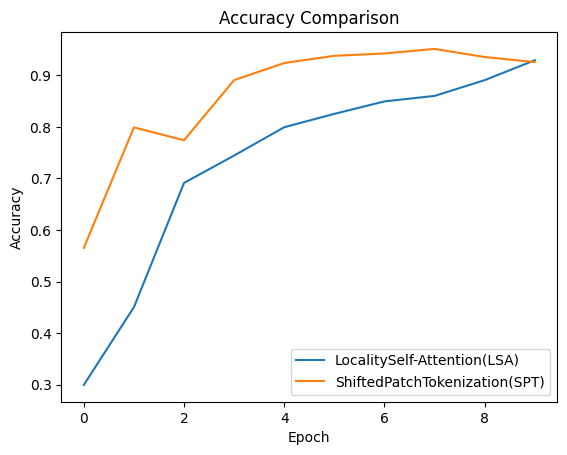

In [ ]:
plt.plot(accuracy_vit2, label='LocalitySelf-Attention(LSA)')
plt.plot(accuracy_vit3, label='ShiftedPatchTokenization(SPT)')
plt.legend()
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()